# Import

In [1]:
import numpy as np
import pandas as pd
import os
import math

from scipy import stats #Analysis 
from scipy.stats import norm 

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [2]:
# 한글 폰트가 깨지면 실행하세요! 
# 한글 폰트가 따로 깔려있지 않은 컴퓨터에서는 해당 cell을 넘겨주세요!!! 
import matplotlib.font_manager as fm
fontlist = fm.findSystemFonts(fontpaths = None, fontext='ttf')
# 아래 주석을 지워서 폰트 리스트를 확인하고 한글 폰트를 font_path에 추가합니다
fontlist[:]

from matplotlib import font_manager, rc
#font_path = 'C:\\Users\\mtang\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquare.ttf'
font_path = 'C:\\WINDOWS\\Fonts\\NanumGothicLight.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 1. Data Load  

**치매 예방을 위한 라이프로그 치매 분류**

**9,327 rows × 66 columns**

For more details https://aihub.or.kr/problem_contest/nipa-learning-platform/6

In [3]:
path = "./Dataset/"

# original data : data 
data =  pd.read_csv(path + "dementia_data.csv", parse_dates=['summary_date']) # 애초에 datatime 유형의 데이터를 읽어 올 때부터 형변환하기
data

,EMAIL,summary_date,activity_average_met,activity_cal_active,activity_cal_total,activity_class_5min,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,...,sleep_temperature_deviation,sleep_temperature_trend_deviation,timezone,sleep_total,CONVERT(activity_class_5min USING utf8),CONVERT(activity_met_1min USING utf8),CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8),DIAG_NM
0,nia+404@rowan.kr,2020-11-27,1.71875,730,2944,...,14346,0,417,0,...,-0.12,99.99,NaN,\r,2/1/1/1/1/1/2/2/1/1/1/1/1/1/2/2/2/3/2/2/2/2/2/...,0.9/0.9/1.4/1.9/1.1/0.9/0.9/1.1/1.3/1/0.9/1.1/...,0/73/73/73/72/71/70/71/71/71/70/70/73/72/74/74...,4/2/4/3/3/1/2/2/2/2/2/2/3/3/3/4/4/3/2/2/2/2/2/...,0/10/10/10/11/11/10/12/18/13/14/12/10/10/18/17...,CN
1,nia+404@rowan.kr,2020-11-28,1.40625,342,2449,...,6352,0,473,0,...,-0.32,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/2/2/2/2/...,1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,69/70/69/69/70/72/71/72/70/69/69/69/68/68/63/6...,2/4/2/2/2/2/3/1/2/2/4/4/2/2/2/2/2/2/2/2/2/2/4/...,23/23/26/24/18/13/15/14/17/20/24/30/23/25/22/1...,CN
2,nia+404@rowan.kr,2020-11-29,1.46875,401,2544,...,7297,0,586,0,...,0.07,99.99,NaN,\r,1/1/1/1/1/1/1/2/1/1/1/1/2/2/2/2/2/1/1/1/1/1/2/...,1.1/1.1/1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/74/73/73/74/74/74/71/71/70/70/69/70/68/66/69...,4/2/4/4/1/1/1/4/4/4/4/4/4/4/2/3/4/2/2/4/2/2/2/...,0/11/14/20/13/14/14/16/27/29/27/20/19/19/14/12...,CN
3,nia+404@rowan.kr,2020-11-30,0.34375,27,1850,...,491,0,176,0,...,-0.41,99.99,NaN,\r,2/1/2/2/1/2/1/1/2/1/1/1/1/1/2/1/1/1/1/1/2/2/2/...,0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/...,73/70/71/72/75/75/73/70/70/70/67/63/63/63/63/6...,4/4/4/4/3/3/3/2/4/4/4/2/2/2/2/2/2/2/2/4/2/2/2/...,24/28/19/17/12/10/17/20/23/23/25/31/26/25/34/3...,CN
4,nia+404@rowan.kr,2020-12-01,1.46875,333,2518,...,5861,0,646,0,...,-0.27,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/3/3/2/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/0/0/0/0/0/0/0/69/69/71/69/65/66/64/64/65/66/...,4/4/4/4/4/4/4/4/4/4/4/2/2/2/2/3/3/2/4/4/4/2/2/...,0/0/0/0/0/0/0/0/21/22/26/23/19/29/22/17/14/13/...,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,nia+206@rowan.kr,2020-12-22,1.34375,227,2316,...,3863,3,735,2,...,-0.16,99.99,NaN,\r,2/1/1/2/2/1/1/1/1/2/2/3/2/1/1/1/1/1/1/1/1/1/1/...,1.1/1.4/1.2/0.9/1.2/1.1/0.9/0.9/0.9/1/0.9/0.9/...,0/54/54/54/55/56/0/0/55/52/52/53/54/54/56/57/6...,4/4/4/2/2/2/2/4/2/2/2/1/1/1/1/4/2/2/3/3/3/3/3/...,0/35/39/28/26/41/0/0/52/31/27/30/21/22/27/40/3...,CN
9323,nia+206@rowan.kr,2020-12-24,1.34375,249,2351,...,4411,1,780,4,...,-0.09,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/2/3/2/2/2/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,68/66/67/67/68/69/69/70/71/71/71/69/72/70/70/7...,4/4/2/2/2/1/1/1/1/1/1/2/2/3/3/2/2/2/2/2/3/4/2/...,26/16/19/18/16/18/19/17/15/16/15/13/11/13/13/1...,CN
9324,nia+206@rowan.kr,2020-12-26,1.53125,570,2682,...,11057,1,518,1,...,0.41,99.99,NaN,\r,1/1/1/1/1/1/2/2/2/2/2/2/1/1/1/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/1.1/0.9/0.9/1.1/0.9/0.9/0.9/0....,0/0/65/65/66/67/69/72/73/72/73/74/73/74/75/75/...,4/4/2/2/2/2/2/2/2/2/2/2/4/4/4/4/2/3/3/3/2/2/4/...,0/0/13/12/12/13/12/12/12/16/13/12/13/17/13/18/...,CN
9325,nia+206@rowan.kr,2020-12-27,1.34375,295,2331,...,5135,4,578,0,...,0.27,99.99,NaN,\r,1/1/1/2/3/2/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,1.1/0.9/0.9/0.9/1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/...,0/0/0/64/64/64/64/65/65/66/66/66/66/68/68/68/6...,4/4/4/4/2/2/2/2/2/2/2/2/2/3/3/3/3/2/4/4/2/2/2/...,0/0/0/14/17/18/14/14/17/15/17/12/17/12/13/12/1...,CN


# 2. EDA  

**9,327 rows × 66 columns**

148명에 대한 데일리 라이프로그 데이터  
크게 **1. 기본 정보 2. 걸음거리 3.수면 4.컨버팅 데이터**로 나눌 수 있겠습니다. 

**1. basic (3 cols)**
- timezone 시간 장소 정보 
    - drop 
    - 완벽한 null variable 
- EMAIL
    - drop
    - 식별자 feature 
- summary_date
    - pandas datetime type으로 사용

**2. activity (26 cols)**
- activity_class_5min, activity_met_1min, 하루간 5분당 활동 로그,하루간 1분당 MET 로그
    - drop 
    - BLOB type -> js로 읽을 수 있다고는 함 

**3. sleep (31 cols)**
- sleep_is_longest, 본 수면 여부 
    - 전부 다 1 
- sleep_temperature_trend_deviation, 피부 온도 경향 편차 
    - 전부 다 99.99
- sleep_total, 수면 시간 
    - 전부 다 \r
- sleep_temperature_deviation 
    - drop 
    - sleep_temperature_delta 랑 같은 변수 
    - sleep_temperature_deviation 을 drop 하고 delta를 남길 것 
- sleep_hr_5min, sleep_hypnogram_5min, sleep_rmssd_5min
    - 5분 당 심박동로그, 수면 상태 로그, 5분당 심박동변동 로그
    - drop 
    - BLOB type 

**4. converting**
- CONVERT(activity_class_5min USING utf8)    
- CONVERT(activity_met_1min USING utf8)      
- CONVERT(sleep_hr_5min USING utf8)          
- CONVERT(sleep_hypnogram_5min USING utf8)  
- CONVERT(sleep_rmssd_5min USING utf8) 

**y variable**
- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9327 entries, 0 to 9326
Data columns (total 66 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   EMAIL                                     9327 non-null   object        
 1   summary_date                              9327 non-null   datetime64[ns]
 2   activity_average_met                      9327 non-null   float64       
 3   activity_cal_active                       9327 non-null   int64         
 4   activity_cal_total                        9327 non-null   int64         
 5   activity_class_5min                       9327 non-null   object        
 6   activity_daily_movement                   9327 non-null   int64         
 7   activity_high                             9327 non-null   int64         
 8   activity_inactive                         9327 non-null   int64         
 9   activity_inactivity_alerts    

# 3. Preprocessing 

**9,327 rows × 66 columns**

**9,327 rows × 49 columns**

**===================Default 하게 진행======================**

모델, 알고리즘과 상관없이 반드시 해당 전처리는 수행할 것

**feature drop**
- timezone
- EMAIL
- sleep_temperature_trend_deviation, sleep_is_longest, sleep_total
    - 모든 값이 1, '\r', 99.99 이므로 제거 
- sleep_temperature_deviation
    - sleep_temperature_delta 변수와 중복되므로 deviation 변수를 제거
- activity_class_5min, activity_met_1min
    - convert data
- sleep_hr_5min, sleep_hypnogram_5min, sleep_rmssd_5min
    - convert data

- CONVERT(activity_class_5min USING utf8)    
- CONVERT(activity_met_1min USING utf8)      
- CONVERT(sleep_hr_5min USING utf8)          
- CONVERT(sleep_hypnogram_5min USING utf8)  
- CONVERT(sleep_rmssd_5min USING utf8) 

**===================Optional 하게 진행======================**

각각을 실험해보고 모델과 가장 궁합이 좋은 전처리 기법도 찾아보자

**Scaling**
- Standard Scaler 
- Robust Scaler 

**Transform**
- Log Transform 
- Quantile Transform 

**PCA**

**=========================Y Varible=========================**

- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)
    - Lable Encoding 
    - 모델마다 y 변수를 자동으로 label encoding 기능을 지원하기도 하지만 공통적으로 진행하고 넘어갑시다 
    
So we may use 49 columns for training...

In [212]:
# data를 따로 관리합니다 
# original data -> data 
# preprocessing data -> processed_data
processed_data = data.copy()

In [213]:
# Feature Selection - column drop 
# drop 할 column을 아래와 같이 묶어서 정리합니다 
# summary_date 추가 
drop_cols = ['timezone', 'EMAIL',
             'activity_class_5min', 'activity_met_1min', 
             'sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min',
             'sleep_is_longest', 'sleep_temperature_trend_deviation', 'sleep_total', 'sleep_temperature_deviation',
             'summary_date']
convert_cols = data.iloc[:, 60:65].columns

processed_data = processed_data.drop(drop_cols, axis=1)
processed_data = processed_data.drop(convert_cols, axis=1)
# 9327 x 49 

Optional

In [203]:
# Log Transform and Quantile Transform 
# right skewed -> log transform -> 13개 
# left skewed -> quantile transform -> 8개
# sleep_midpoint_delta -> log tranform에서 error 남 => 제외했음 
# https://yashowardhanshinde.medium.com/what-is-skewness-in-data-how-to-fix-skewed-data-in-python-a792e98c0fa6
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, Normalizer, power_transform, QuantileTransformer 

def quantileTransform(data) : 
    qt = QuantileTransformer()
    scaled_data = pd.DataFrame(qt.fit_transform(data), columns=data.columns)
    return scaled_data

def logTransform(data) :
    scaled_cols = data.columns
    scaled_data = data.apply(lambda x: np.log1p(x))
    return scaled_data

left_skewed_cols = ['sleep_efficiency', 'sleep_score_alignment', 'sleep_score_deep', 'sleep_score_latency', 'sleep_score_total',
                    'activity_score', 'activity_score_stay_active', 'activity_score_training_volume']
right_skewed_cols = ['activity_cal_active', 'activity_daily_movement', 'activity_high', 'activity_medium', 'activity_met_min_high', 
                     'activity_met_min_inactive', 'activity_met_min_low', 'activity_met_min_medium', 'activity_non_wear', 
                     'activity_steps', 'sleep_awake', 'sleep_onset_latency', 'sleep_rmssd']

print(len(left_skewed_cols))
print(len(right_skewed_cols))

processed_data[left_skewed_cols] = quantileTransform(processed_data[left_skewed_cols])
processed_data[right_skewed_cols] = logTransform(processed_data[right_skewed_cols])
processed_data.head()

8
13


,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,DIAG_NM
0,1.71875,6.594413,2944,9.571296,0.0,417,0,545,3.871201,0.0,...,62,1.0,0.112112,50,27,0.912913,66,0.304304,-0.12,CN
1,1.40625,5.837730,2449,8.756682,0.0,473,0,392,2.197225,0.0,...,54,1.0,0.140140,43,46,0.763263,35,0.112112,-0.32,CN
2,1.46875,5.996452,2544,8.895356,0.0,586,0,362,3.218876,0.0,...,61,1.0,0.177177,47,34,0.687688,41,0.304304,0.07,CN
3,0.34375,3.332205,1850,6.198479,0.0,176,0,34,0.693147,0.0,...,55,1.0,0.085586,40,44,0.621622,29,0.226727,-0.41,CN
4,1.46875,5.811141,2518,8.676246,0.0,646,0,377,1.945910,0.0,...,56,1.0,0.217217,55,39,0.008577,54,0.264765,-0.27,CN


In [204]:
# Scaling 
standardScaler = RobustScaler()
scaled_data = processed_data.iloc[:, :48].copy()
scaled_data = pd.DataFrame(standardScaler.fit_transform(scaled_data), columns = scaled_data.columns)
processed_data.iloc[:, :48]=scaled_data

processed_data.head()

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,DIAG_NM
0,1.285714,0.665495,1.086168,0.668473,-0.5,-0.527174,0.0,1.658537,0.075683,-0.663194,...,-0.8125,0.0,-0.807365,-0.941176,-1.857143,0.750000,0.188679,-0.395137,-0.342857,CN
1,-0.142857,-0.231609,-0.036281,-0.233596,-0.5,-0.222826,0.0,0.725610,-1.076056,-0.663194,...,-1.3125,0.0,-0.754485,-1.352941,-1.178571,0.479167,-0.396226,-0.784195,-0.914286,CN
2,0.142857,-0.043432,0.179138,-0.080035,-0.5,0.391304,0.0,0.542683,-0.373133,-0.663194,...,-0.8750,0.0,-0.684608,-1.117647,-1.607143,0.342391,-0.283019,-0.395137,0.200000,CN
3,-5.000000,-3.202093,-1.394558,-3.066443,-0.5,-1.836957,0.0,-1.457317,-2.110900,-0.663194,...,-1.2500,0.0,-0.857413,-1.529412,-1.250000,0.222826,-0.509434,-0.552178,-1.171429,CN
4,0.142857,-0.263132,0.120181,-0.322668,-0.5,0.717391,0.0,0.634146,-1.248967,-0.663194,...,-1.1875,0.0,-0.609065,-0.647059,-1.428571,-0.886651,-0.037736,-0.475177,-0.771429,CN


In [135]:
# PCA
from sklearn.decomposition import PCA

processed_data_y = processed_data['DIAG_NM']
processed_data_X = processed_data.drop('DIAG_NM', axis=1)

pca = PCA(n_components=4)
processed_data_X = pca.fit_transform(processed_data_X)
processed_data_X = pd.DataFrame(processed_data_X)

processed_data = pd.concat([processed_data_X, processed_data_y], axis=1)
processed_data

,0,1,2,3,DIAG_NM
0,-2272.167797,-4082.705104,10869.621333,5460.303368,CN
1,-1873.906100,2416.942852,-5907.759760,1302.340460,CN
2,-3274.713459,-7894.290564,1073.547860,3663.760972,CN
3,-2363.280486,-6632.427668,-5017.978415,793.079395,CN
4,-3301.608111,-6596.087116,-1586.732328,3761.377515,CN
...,...,...,...,...,...
9322,-212.661636,-8805.395903,-3942.173720,-2286.131025,CN
9323,-631.071246,-9610.555311,-2620.013956,-3518.688165,CN
9324,-1361.451197,1315.911394,2094.558774,-3105.802547,CN
9325,2621.706626,-10860.591238,-305.533632,-6249.076234,CN


# 4. Data Split 

모든 전처리와 y variable labeling이 완료되었다.  
train / valid / test data로 분할하고 용도에 맞게 model을 돌리도록 하자. 

In [214]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV

# data를 따로 관리합니다 
# preprocessing data -> processed_data
# input data -> input_data
input_data = processed_data.copy()

# y 변수와 X 변수 분할 관리 
input_data_y = input_data['DIAG_NM'].copy()
input_data_X = input_data.drop(['DIAG_NM'], axis=1)

In [215]:
# LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
input_data_y = le.fit_transform(list(input_data_y))
print("original gain_label \n", le.classes_)
print("gain_lable label \n", set(input_data_y))

original gain_label 
 ['CN' 'Dem' 'MCI']
gain_lable label 
 {0, 1, 2}


In [216]:
# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

# 5. Modeling - ML

- Linear model
    - **Logistic Linear Regression** 
    - solver : newton-cg, lbfgs, sag, saga (sag, saga는 데이터가 클 때 좋음) 
    - newton-cg - (l2, none), lbfgs - (l2, none),  
    - 이중 분류가 아니기 때문에 'liblinear' optimizer를 사용할 수 없음
    - multi_class : default = auto, 현재는 multinomial 
- Tree model 
    - decision Tree (pruning)
    - RandomForest (Ensemble model?)
- Gradient Boosting model 
    - XGB
    - LGBM
    - CatBoost 

In [170]:
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from subprocess import call

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier
from lightgbm import plot_importance 
from catboost import CatBoostClassifier
# Learning task parameters
# multi:softmax : softmax를 이용한 다중 클래스 분류 
# multi:softptob : softmax를 이용한 다중 클래스에 대한 예상 확률 반환 
# mlogloss : multiclass logloss 
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

### logistic regression

In [13]:
model_lr = LogisticRegression(max_iter=1000, solver='newton-cg')

In [14]:
# warning : 'max_iter'까지 학습했으나 정답에 수렴하지 못한 상태 
# warning : https://www.inflearn.com/questions/62388 -> 철민이형 답변 
# warning : For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga', 'lbfgs’ handle multinomial loss
# warning : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
model_lr.fit(tr_val_X, tr_val_y)

C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


LogisticRegression(max_iter=1000, solver='newton-cg')

In [15]:
print(model_lr.score(tr_val_X, tr_val_y))
print(model_lr.score(test_X, test_y))

0.6875753920386007
0.6672025723472669


In [16]:
# https://sefiks.com/2021/01/06/feature-importance-in-logistic-regression/ 
# logistic regression interpretability 
w0 = model_lr.intercept_[0]
w = model_lr.coef_[0]

<AxesSubplot:xlabel='importance', ylabel='feature'>

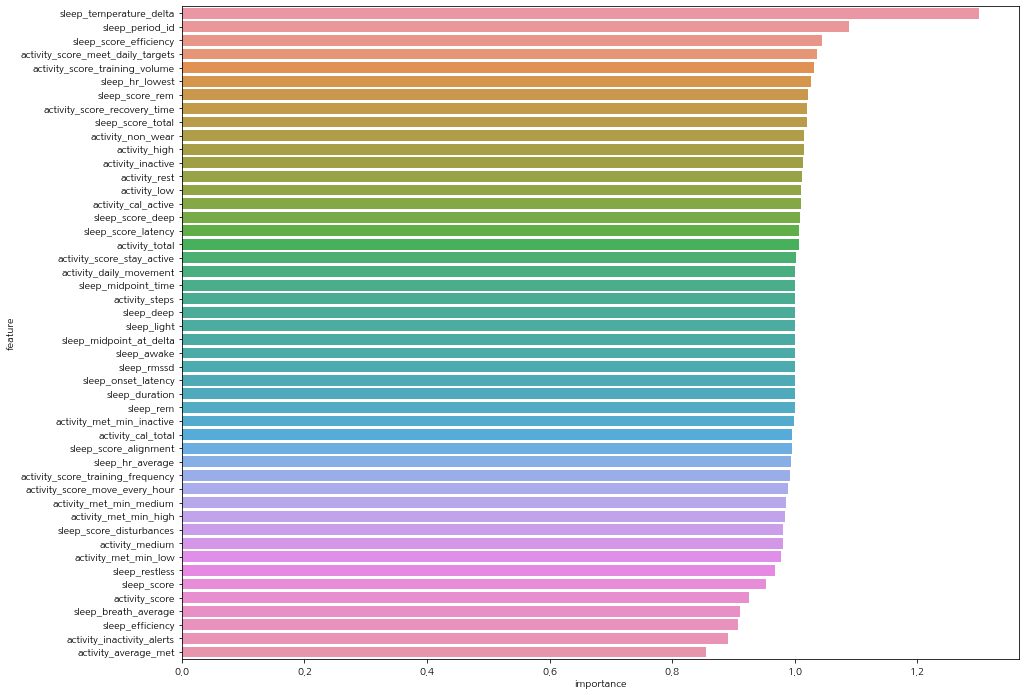

In [17]:
feature_importance = pd.DataFrame(test_X.columns, columns=["feature"])
feature_importance["importance"] = pow(math.e, w)
feature_importance = feature_importance.sort_values(by=["importance"], ascending=False)

plt.figure(figsize = (15,12))
sns.barplot(data=feature_importance, x="importance", y="feature")

In [215]:
# feature importance 가 1 이하인 것들을 제거해보고 진행해봅니다 
# 23개의 feature가 drop 되고 48개에서 25개만 남게 되겠네요
not_necessary = feature_importance[feature_importance["importance"]<1]["feature"].values
print(len(not_necessary))
print(not_necessary)

25
['activity_score_recovery_time' 'sleep_score_efficiency' 'activity_score'
 'sleep_rem' 'activity_met_min_inactive' 'activity_score_move_every_hour'
 'activity_inactivity_alerts' 'sleep_onset_latency'
 'activity_score_training_volume' 'sleep_breath_average'
 'sleep_score_total' 'sleep_score' 'activity_cal_total' 'sleep_deep'
 'activity_score_training_frequency' 'sleep_score_alignment'
 'activity_met_min_high' 'activity_score_stay_active'
 'sleep_score_disturbances' 'activity_rest' 'sleep_restless'
 'activity_inactive' 'activity_cal_active' 'sleep_duration'
 'activity_total']


feature selection 끝! 

In [216]:
input_data_X2 = input_data_X.drop(not_necessary, axis=1)
input_data_X2.head()

,activity_average_met,activity_daily_movement,activity_high,activity_low,activity_medium,activity_met_min_low,activity_met_min_medium,activity_non_wear,activity_score_meet_daily_targets,activity_steps,...,sleep_hr_lowest,sleep_light,sleep_midpoint_at_delta,sleep_midpoint_time,sleep_period_id,sleep_rmssd,sleep_score_deep,sleep_score_latency,sleep_score_rem,sleep_temperature_delta
0,1.285714,0.668473,-0.5,1.658537,0.075683,1.253033,0.155530,0.428226,0.000,0.583640,...,0.777778,0.070707,-0.251153,0.630872,-1.0,-0.762422,-0.807365,0.750000,0.188679,-0.342857
1,-0.142857,-0.233596,-0.5,0.725610,-1.076056,0.483671,-1.065624,0.406597,-0.425,-0.277080,...,0.888889,-0.404040,0.305631,-0.664430,-1.0,-0.857935,-0.754485,0.479167,-0.396226,-0.914286
2,0.142857,-0.080035,-0.5,0.542683,-0.373133,0.432317,-0.328072,0.157293,0.000,-0.189502,...,0.444444,0.196970,-0.434795,0.671141,-1.0,-0.270445,-0.684608,0.342391,-0.283019,0.200000
3,-5.000000,-3.066443,-0.5,-1.457317,-2.110900,-3.125917,-2.267144,0.314586,0.000,-0.221490,...,0.222222,0.292929,-0.170901,0.288591,-1.0,0.000000,-0.857413,0.222826,-0.509434,-1.171429
4,0.142857,-0.322668,-0.5,0.634146,-1.248967,0.432317,-1.211927,0.314586,0.000,-0.336994,...,0.555556,-0.101010,-0.347221,0.617450,-1.0,-0.501019,-0.609065,-0.886651,-0.037736,-0.771429


In [217]:
# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X2, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

In [218]:
model_lr = LogisticRegression(max_iter=1000, solver='newton-cg')
model_lr.fit(tr_val_X, tr_val_y)

print(model_lr.score(tr_val_X, tr_val_y))
print(model_lr.score(test_X, test_y))

0.6508510923468704
0.6484458735262594


중요도 낮은 feature를 pca로 묶어버리기 

In [200]:
pca = PCA(n_components=4)
pca_data = pca.fit_transform(input_data_X[not_necessary])
pca_data = pd.DataFrame(pca_data)

input_data_X = input_data_X.drop(not_necessary, axis=1)
input_data_X = pd.concat([input_data_X, pca_data], axis=1)
input_data_X

,activity_cal_active,activity_daily_movement,activity_high,activity_inactive,activity_low,activity_non_wear,activity_rest,activity_score_meet_daily_targets,activity_score_recovery_time,activity_score_stay_active,...,sleep_score_deep,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,0,1,2,3
0,730,14346,0,417,545,32,399,95,100,86,...,41,27,97,66,62,-0.12,8745.781720,5205.146185,-2217.055436,-129.982015
1,342,6352,0,473,392,29,538,78,100,83,...,49,46,91,35,44,-0.32,-3666.413467,3478.161454,-1003.884596,-135.760461
2,401,7297,0,586,362,9,459,95,100,71,...,56,34,89,41,62,0.07,5743.947920,4793.364710,-612.371108,177.677910
3,27,491,0,176,34,19,1210,95,100,74,...,35,44,86,29,56,-0.41,1566.914313,4112.081227,-17.252671,306.445278
4,333,5861,0,646,377,19,392,95,100,65,...,64,39,14,54,59,-0.27,3812.479386,3925.581880,-1457.715594,2411.314682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,227,3863,3,735,155,0,530,43,100,49,...,53,74,97,84,82,-0.16,3776.910422,-1090.990063,-861.533231,52.362351
9323,249,4411,1,780,167,0,470,25,100,45,...,34,76,81,95,86,-0.09,4314.371906,-1928.102964,-1195.039789,-303.342512
9324,570,11057,1,518,332,0,528,43,100,76,...,1,69,86,89,64,0.41,-1081.506508,-598.825466,-2319.799570,-185.272605
9325,295,5135,4,578,173,0,655,25,100,70,...,9,86,89,98,97,0.27,6146.706837,-3876.112537,-1455.732410,417.369144


In [201]:
# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

model_lr = LogisticRegression(max_iter=1000, solver='newton-cg')
model_lr.fit(tr_val_X, tr_val_y)

print(model_lr.score(tr_val_X, tr_val_y))
print(model_lr.score(test_X, test_y))

C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Hyeongbin\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Hyeongbin\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


0.6629138185229861
0.662379421221865


C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Hyeongbin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


### Decision Tree 

In [145]:
model_dt = DecisionTreeClassifier()

In [146]:
model_dt.fit(tr_val_X, tr_val_y)

DecisionTreeClassifier()

In [ ]:
export_graphviz(
    model_dt,
    out_file='tree.dot')

# 예측한 모형 png로 바꿔서 시각화 하기
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

### Random Forest

In [63]:
model_rf = RandomForestClassifier()

In [64]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X.iloc[train_index], input_data_X.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_rf.fit(x_train, y_train)
    pred = model_rf.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.4823,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]

#2 교차 검증 정확도 : 0.6615,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]

#3 교차 검증 정확도 : 0.5677,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]

#4 교차 검증 정확도 : 0.5489,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]

#5 교차 검증 정확도 : 0.5342,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.55892


In [65]:
pred_rf = model_rf.predict(test_X)
print(classification_report(test_y, pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1194
           1       0.94      0.83      0.88       129
           2       0.93      0.71      0.80       543

    accuracy                           0.88      1866
   macro avg       0.91      0.84      0.87      1866
weighted avg       0.89      0.88      0.88      1866



<AxesSubplot:xlabel='importance', ylabel='feature'>

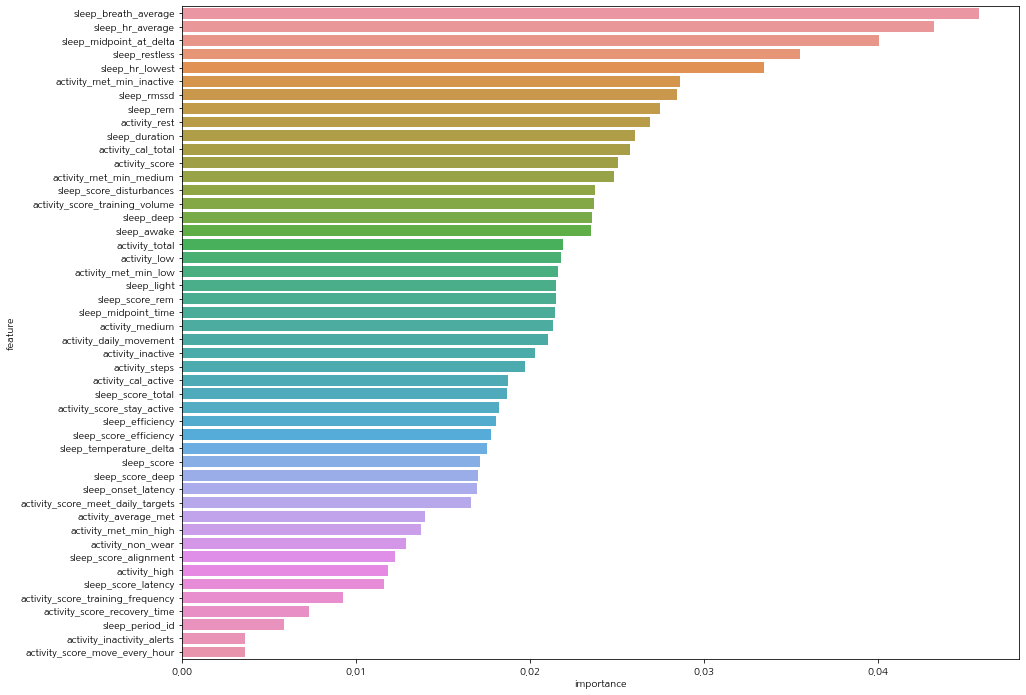

In [66]:
# RF, DT의 feature importance 는 Gini Impurity 기반의 것만 제공합니다 
feature_importance = pd.DataFrame(test_X.columns, columns=["feature"])
feature_importance["importance"] = model_rf.feature_importances_
feature_importance = feature_importance.sort_values(by=["importance"], ascending=False)

plt.figure(figsize = (15,12))
sns.barplot(data=feature_importance, x="importance", y="feature")

In [67]:
# feature importance 에서 순위가 낮은 19개의 변수를 없애고 상위 30개의 변수에 대해서만 학습해 봅시다 
not_necessary = feature_importance.tail(18)["feature"].values
print(len(not_necessary))
print(not_necessary)

18
['sleep_efficiency' 'sleep_score_efficiency' 'sleep_temperature_delta'
 'sleep_score' 'sleep_score_deep' 'sleep_onset_latency'
 'activity_score_meet_daily_targets' 'activity_average_met'
 'activity_met_min_high' 'activity_non_wear' 'sleep_score_alignment'
 'activity_high' 'sleep_score_latency' 'activity_score_training_frequency'
 'activity_score_recovery_time' 'sleep_period_id'
 'activity_inactivity_alerts' 'activity_score_move_every_hour']


In [74]:
input_data_X2 = input_data_X.drop(not_necessary, axis=1)

# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X2, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

In [76]:
model_rf2 = RandomForestClassifier()

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X2.iloc[train_index], input_data_X2.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_rf2.fit(x_train, y_train)
    pred = model_rf2.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.4863,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]

#2 교차 검증 정확도 : 0.6588,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]

#3 교차 검증 정확도 : 0.5744,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]

#4 교차 검증 정확도 : 0.5583,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]

#5 교차 검증 정확도 : 0.5308,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.56172


In [77]:
pred_rf = model_rf2.predict(test_X)
print(classification_report(test_y, pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1194
           1       0.93      0.83      0.88       129
           2       0.90      0.71      0.79       543

    accuracy                           0.88      1866
   macro avg       0.90      0.83      0.86      1866
weighted avg       0.88      0.88      0.87      1866



### AdaBoost

In [217]:
model_ab = AdaBoostClassifier()

In [218]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X.iloc[train_index], input_data_X.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_ab.fit(x_train, y_train)
    pred = model_ab.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.5338,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]

#2 교차 검증 정확도 : 0.4732,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]

#3 교차 검증 정확도 : 0.5362,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]

#4 교차 검증 정확도 : 0.5114,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]

#5 교차 검증 정확도 : 0.4739,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.5057


In [219]:
pred_ab = model_ab.predict(test_X)
print(classification_report(test_y, pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1194
           1       0.93      0.83      0.88       129
           2       0.90      0.71      0.79       543

    accuracy                           0.88      1866
   macro avg       0.90      0.83      0.86      1866
weighted avg       0.88      0.88      0.87      1866



<AxesSubplot:xlabel='importance', ylabel='feature'>

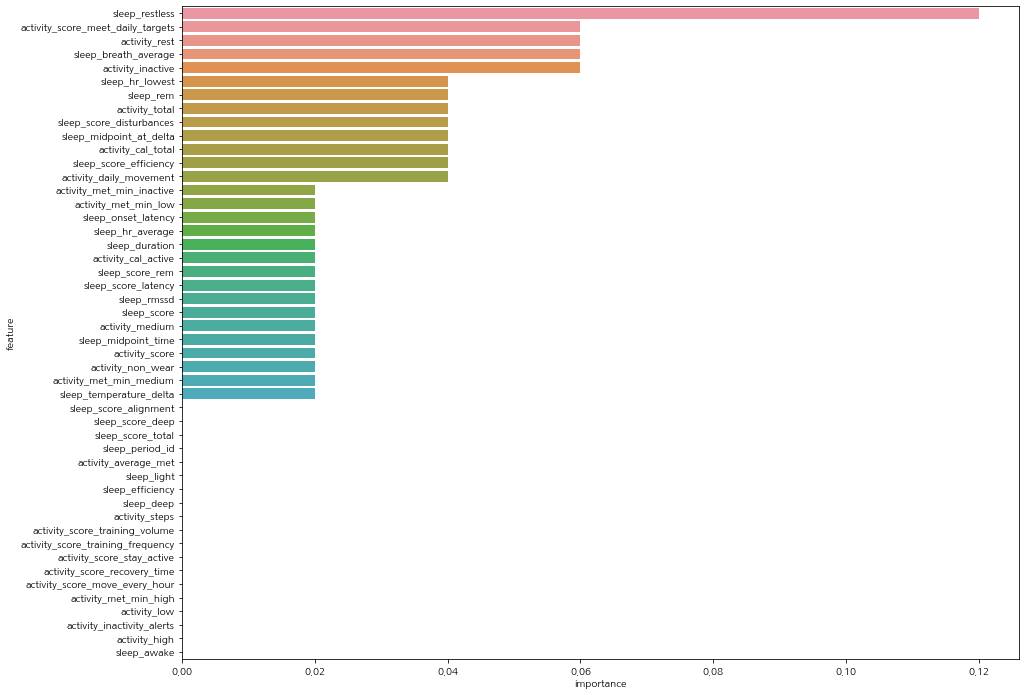

In [220]:
feature_importance = pd.DataFrame(test_X.columns, columns=["feature"])
feature_importance["importance"] = model_ab.feature_importances_
feature_importance = feature_importance.sort_values(by=["importance"], ascending=False)

plt.figure(figsize = (15,12))
sns.barplot(data=feature_importance, x="importance", y="feature")

In [221]:
# feature importance 에서 순위가 낮은 19개의 변수를 없애고 상위 30개의 변수에 대해서만 학습해 봅시다 
not_necessary = feature_importance.tail(18)["feature"].values
print(len(not_necessary))
print(not_necessary)

18
['sleep_score_deep' 'sleep_score_total' 'sleep_period_id'
 'activity_average_met' 'sleep_light' 'sleep_efficiency' 'sleep_deep'
 'activity_steps' 'activity_score_training_volume'
 'activity_score_training_frequency' 'activity_score_stay_active'
 'activity_score_recovery_time' 'activity_score_move_every_hour'
 'activity_met_min_high' 'activity_low' 'activity_inactivity_alerts'
 'activity_high' 'sleep_awake']


In [222]:
input_data_X2 = input_data_X.drop(not_necessary, axis=1)

# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X2, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

In [223]:
model_ab2 = AdaBoostClassifier()

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X2.iloc[train_index], input_data_X2.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_ab2.fit(x_train, y_train)
    pred = model_ab2.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.5687,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]

#2 교차 검증 정확도 : 0.4765,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]

#3 교차 검증 정확도 : 0.5483,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]

#4 교차 검증 정확도 : 0.508,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]

#5 교차 검증 정확도 : 0.4739,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.51508


In [224]:
pred_ab = model_ab2.predict(test_X)
print(classification_report(test_y, pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1194
           1       0.93      0.83      0.88       129
           2       0.90      0.71      0.79       543

    accuracy                           0.88      1866
   macro avg       0.90      0.83      0.86      1866
weighted avg       0.88      0.88      0.87      1866



### XGB

In [90]:
model_xgb = XGBClassifier(
    eval_metric='mlogloss', use_label_encoder=False )

In [91]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X.iloc[train_index], input_data_X.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_xgb.fit(x_train, y_train)
    pred = model_xgb.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))

C:\Users\Hyeongbin\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



#1 교차 검증 정확도 : 0.4796,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]


C:\Users\Hyeongbin\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



#2 교차 검증 정확도 : 0.6193,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]


C:\Users\Hyeongbin\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



#3 교차 검증 정확도 : 0.5181,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]


C:\Users\Hyeongbin\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



#4 교차 검증 정확도 : 0.5536,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]


C:\Users\Hyeongbin\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



#5 교차 검증 정확도 : 0.5228,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.53868


In [92]:
pred_xgb_prob = model_xgb.predict_proba(test_X)
pred_xgb = np.argmax(pred_xgb_prob, axis=1)

print(classification_report(test_y, pred_xgb))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1194
           1       0.87      0.85      0.86       129
           2       0.86      0.73      0.79       543

    accuracy                           0.87      1866
   macro avg       0.87      0.84      0.85      1866
weighted avg       0.87      0.87      0.87      1866



<AxesSubplot:xlabel='importance', ylabel='feature'>

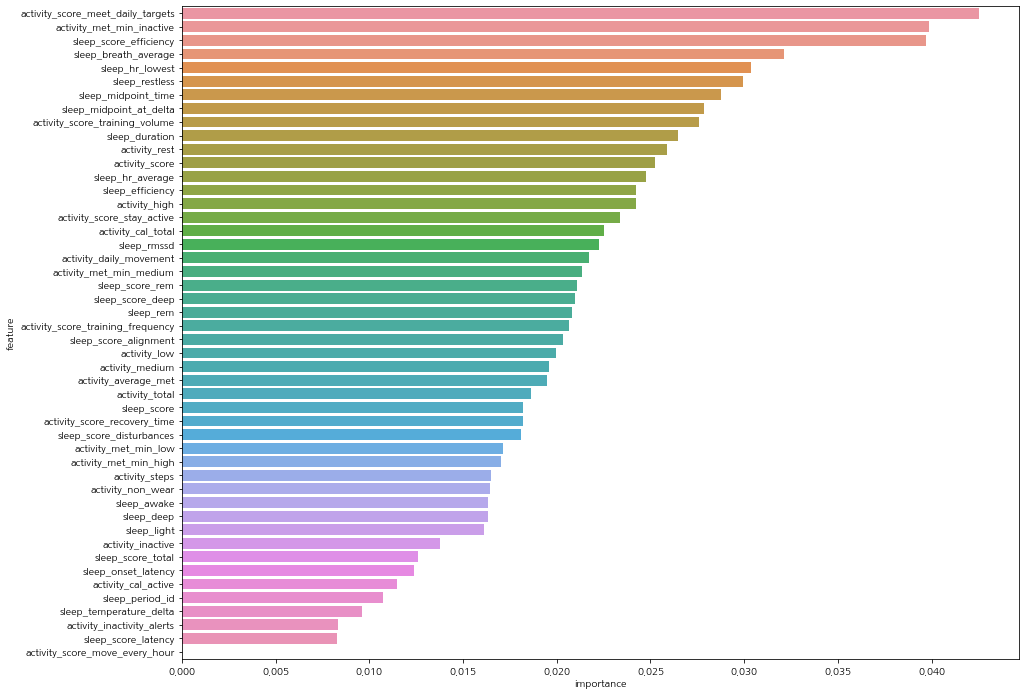

In [93]:
# XGB, LGBM과 같은 Gradient Boosting 계열의 모델은 feature importance를 계산하는 여러가지 option이 존재
# default 는 gain/total gain 
# gain/total gain : featur가 모델 예측에 어느정도 영향을 미쳤는가를 측정하는 방법
# 특정 feature로 분기되었을 때 얻는 성능 상의 이득을 계산 (gini impurity와 비슷)
# 이밖의 option -> cover/total cover, weight 
# 자세한 것은 https://hongl.tistory.com/131
feature_importance = pd.DataFrame(test_X.columns, columns=["feature"])
feature_importance["importance"] = model_xgb.feature_importances_
feature_importance = feature_importance.sort_values(by=["importance"], ascending=False)

plt.figure(figsize = (15,12))
sns.barplot(data=feature_importance, x="importance", y="feature")

In [95]:
# feature importance 에서 순위가 낮은 19개의 변수를 없애고 상위 30개의 변수에 대해서만 학습해 봅시다 
not_necessary = feature_importance.tail(18)["feature"].values
print(len(not_necessary))
print(not_necessary)

18
['activity_score_recovery_time' 'sleep_score_disturbances'
 'activity_met_min_low' 'activity_met_min_high' 'activity_steps'
 'activity_non_wear' 'sleep_awake' 'sleep_deep' 'sleep_light'
 'activity_inactive' 'sleep_score_total' 'sleep_onset_latency'
 'activity_cal_active' 'sleep_period_id' 'sleep_temperature_delta'
 'activity_inactivity_alerts' 'sleep_score_latency'
 'activity_score_move_every_hour']


In [96]:
input_data_X2 = input_data_X.drop(not_necessary, axis=1)

# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X2, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

In [97]:
model_xgb = XGBClassifier(
    eval_metric='mlogloss', use_label_encoder=False )

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X2.iloc[train_index], input_data_X2.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_xgb.fit(x_train, y_train)
    pred = model_xgb.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))

C:\Users\Hyeongbin\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



#1 교차 검증 정확도 : 0.4802,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]


C:\Users\Hyeongbin\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



#2 교차 검증 정확도 : 0.6394,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]


C:\Users\Hyeongbin\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



#3 교차 검증 정확도 : 0.5282,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]


C:\Users\Hyeongbin\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



#4 교차 검증 정확도 : 0.5389,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]


C:\Users\Hyeongbin\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



#5 교차 검증 정확도 : 0.5302,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.54338


In [98]:
pred_xgb_prob = model_xgb.predict_proba(test_X)
pred_xgb = np.argmax(pred_xgb_prob, axis=1)

print(classification_report(test_y, pred_xgb))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1194
           1       0.87      0.88      0.87       129
           2       0.84      0.73      0.78       543

    accuracy                           0.87      1866
   macro avg       0.86      0.85      0.85      1866
weighted avg       0.87      0.87      0.87      1866



### LGBM

In [105]:
model_lgbm = LGBMClassifier()

In [106]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X.iloc[train_index], input_data_X.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_lgbm.fit(x_train, y_train)
    pred = model_lgbm.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.4776,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]

#2 교차 검증 정확도 : 0.6448,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]

#3 교차 검증 정확도 : 0.5349,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]

#4 교차 검증 정확도 : 0.5436,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]

#5 교차 검증 정확도 : 0.5295,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.5460800000000001


In [107]:
pred_lgbm_prob = model_lgbm.predict_proba(test_X)
pred_lgbm = np.argmax(pred_lgbm_prob, axis=1)

print(classification_report(test_y, pred_lgbm))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1194
           1       0.89      0.87      0.88       129
           2       0.86      0.73      0.79       543

    accuracy                           0.87      1866
   macro avg       0.87      0.84      0.86      1866
weighted avg       0.87      0.87      0.87      1866



<AxesSubplot:xlabel='importance', ylabel='feature'>

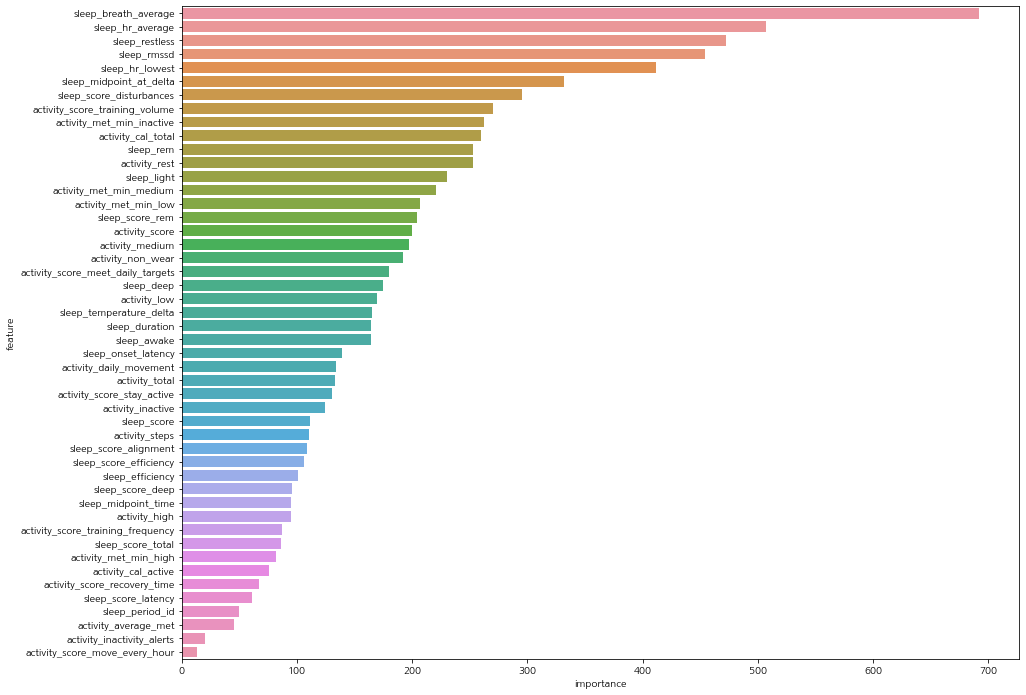

In [108]:
feature_importance = pd.DataFrame(test_X.columns, columns=["feature"])
feature_importance["importance"] = model_lgbm.feature_importances_
feature_importance = feature_importance.sort_values(by=["importance"], ascending=False)

plt.figure(figsize = (15,12))
sns.barplot(data=feature_importance, x="importance", y="feature")

In [109]:
# feature importance 에서 순위가 낮은 19개의 변수를 없애고 상위 30개의 변수에 대해서만 학습해 봅시다 
not_necessary = feature_importance.tail(18)["feature"].values
print(len(not_necessary))
print(not_necessary)

18
['sleep_score' 'activity_steps' 'sleep_score_alignment'
 'sleep_score_efficiency' 'sleep_efficiency' 'sleep_score_deep'
 'sleep_midpoint_time' 'activity_high' 'activity_score_training_frequency'
 'sleep_score_total' 'activity_met_min_high' 'activity_cal_active'
 'activity_score_recovery_time' 'sleep_score_latency' 'sleep_period_id'
 'activity_average_met' 'activity_inactivity_alerts'
 'activity_score_move_every_hour']


In [110]:
input_data_X2 = input_data_X.drop(not_necessary, axis=1)

# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X2, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

In [111]:
model_lgbm2 = LGBMClassifier()

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X2.iloc[train_index], input_data_X2.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_lgbm2.fit(x_train, y_train)
    pred = model_lgbm2.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.4836,  학습 데이터 크기 : 5968,  검증 데이터 크기 : 1493
#1 검증 세트 인덱스 : [   0    1    2 ... 1523 1524 1525]

#2 교차 검증 정확도 : 0.6448,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]

#3 교차 검증 정확도 : 0.5355,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]

#4 교차 검증 정확도 : 0.559,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]

#5 교차 검증 정확도 : 0.5315,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.55088


In [112]:
pred_lgbm_prob = model_lgbm2.predict_proba(test_X)
pred_lgbm = np.argmax(pred_lgbm_prob, axis=1)

print(classification_report(test_y, pred_lgbm))

              precision    recall  f1-score   support

           0       0.88      0.94      0.90      1194
           1       0.87      0.87      0.87       129
           2       0.86      0.73      0.79       543

    accuracy                           0.87      1866
   macro avg       0.87      0.84      0.85      1866
weighted avg       0.87      0.87      0.87      1866



### CatBoost

In [118]:
# Categorical 범주에 적잡한 알고리즘 
# 수치형 변수가 많다면 lightGBM보다 학습 속도가느릴 수 있음 
model_cat = CatBoostClassifier()

In [119]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X.iloc[train_index], input_data_X.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_cat.fit(x_train, y_train)
    pred = model_cat.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))

Learning rate set to 0.086674
0:	learn: 1.0507875	total: 163ms	remaining: 2m 42s
1:	learn: 1.0120067	total: 173ms	remaining: 1m 26s
2:	learn: 0.9757200	total: 184ms	remaining: 1m 1s
3:	learn: 0.9452100	total: 198ms	remaining: 49.2s
4:	learn: 0.9175665	total: 208ms	remaining: 41.4s
5:	learn: 0.8932527	total: 218ms	remaining: 36.1s
6:	learn: 0.8738848	total: 229ms	remaining: 32.5s
7:	learn: 0.8537387	total: 239ms	remaining: 29.7s
8:	learn: 0.8351611	total: 250ms	remaining: 27.5s
9:	learn: 0.8181381	total: 262ms	remaining: 25.9s
10:	learn: 0.8018156	total: 272ms	remaining: 24.4s
11:	learn: 0.7888478	total: 282ms	remaining: 23.2s
12:	learn: 0.7765993	total: 292ms	remaining: 22.1s
13:	learn: 0.7644760	total: 302ms	remaining: 21.2s
14:	learn: 0.7564929	total: 312ms	remaining: 20.5s
15:	learn: 0.7459093	total: 322ms	remaining: 19.8s
16:	learn: 0.7368455	total: 332ms	remaining: 19.2s
17:	learn: 0.7261270	total: 342ms	remaining: 18.6s
18:	learn: 0.7178481	total: 353ms	remaining: 18.2s
19:	learn

167:	learn: 0.3459730	total: 2s	remaining: 9.88s
168:	learn: 0.3442999	total: 2s	remaining: 9.86s
169:	learn: 0.3431858	total: 2.02s	remaining: 9.85s
170:	learn: 0.3422828	total: 2.03s	remaining: 9.83s
171:	learn: 0.3402830	total: 2.04s	remaining: 9.8s
172:	learn: 0.3395476	total: 2.05s	remaining: 9.79s
173:	learn: 0.3384492	total: 2.06s	remaining: 9.77s
174:	learn: 0.3375206	total: 2.07s	remaining: 9.75s
175:	learn: 0.3368017	total: 2.08s	remaining: 9.73s
176:	learn: 0.3352265	total: 2.09s	remaining: 9.72s
177:	learn: 0.3333464	total: 2.1s	remaining: 9.7s
178:	learn: 0.3324499	total: 2.11s	remaining: 9.69s
179:	learn: 0.3312028	total: 2.12s	remaining: 9.67s
180:	learn: 0.3302624	total: 2.13s	remaining: 9.65s
181:	learn: 0.3295199	total: 2.14s	remaining: 9.63s
182:	learn: 0.3285030	total: 2.15s	remaining: 9.61s
183:	learn: 0.3274034	total: 2.16s	remaining: 9.6s
184:	learn: 0.3265703	total: 2.17s	remaining: 9.58s
185:	learn: 0.3257950	total: 2.19s	remaining: 9.57s
186:	learn: 0.3250810	

341:	learn: 0.2206780	total: 3.96s	remaining: 7.62s
342:	learn: 0.2202972	total: 3.97s	remaining: 7.61s
343:	learn: 0.2194078	total: 3.98s	remaining: 7.59s
344:	learn: 0.2189084	total: 3.99s	remaining: 7.58s
345:	learn: 0.2184235	total: 4s	remaining: 7.57s
346:	learn: 0.2180149	total: 4.01s	remaining: 7.55s
347:	learn: 0.2172524	total: 4.02s	remaining: 7.54s
348:	learn: 0.2166607	total: 4.03s	remaining: 7.53s
349:	learn: 0.2161510	total: 4.04s	remaining: 7.51s
350:	learn: 0.2159174	total: 4.05s	remaining: 7.5s
351:	learn: 0.2155018	total: 4.07s	remaining: 7.48s
352:	learn: 0.2151652	total: 4.08s	remaining: 7.47s
353:	learn: 0.2149674	total: 4.08s	remaining: 7.46s
354:	learn: 0.2145909	total: 4.1s	remaining: 7.44s
355:	learn: 0.2141523	total: 4.11s	remaining: 7.43s
356:	learn: 0.2136211	total: 4.12s	remaining: 7.42s
357:	learn: 0.2132140	total: 4.13s	remaining: 7.4s
358:	learn: 0.2127395	total: 4.14s	remaining: 7.39s
359:	learn: 0.2123277	total: 4.15s	remaining: 7.38s
360:	learn: 0.2119

507:	learn: 0.1593189	total: 5.73s	remaining: 5.55s
508:	learn: 0.1591370	total: 5.74s	remaining: 5.54s
509:	learn: 0.1589197	total: 5.75s	remaining: 5.52s
510:	learn: 0.1587397	total: 5.76s	remaining: 5.51s
511:	learn: 0.1584898	total: 5.77s	remaining: 5.5s
512:	learn: 0.1580626	total: 5.78s	remaining: 5.49s
513:	learn: 0.1579107	total: 5.79s	remaining: 5.48s
514:	learn: 0.1575696	total: 5.8s	remaining: 5.46s
515:	learn: 0.1573029	total: 5.81s	remaining: 5.45s
516:	learn: 0.1569536	total: 5.82s	remaining: 5.44s
517:	learn: 0.1567601	total: 5.83s	remaining: 5.43s
518:	learn: 0.1564439	total: 5.84s	remaining: 5.42s
519:	learn: 0.1560901	total: 5.85s	remaining: 5.4s
520:	learn: 0.1558592	total: 5.87s	remaining: 5.39s
521:	learn: 0.1555122	total: 5.88s	remaining: 5.38s
522:	learn: 0.1552998	total: 5.89s	remaining: 5.37s
523:	learn: 0.1550453	total: 5.9s	remaining: 5.36s
524:	learn: 0.1548107	total: 5.91s	remaining: 5.35s
525:	learn: 0.1545657	total: 5.92s	remaining: 5.34s
526:	learn: 0.15

677:	learn: 0.1216291	total: 7.53s	remaining: 3.58s
678:	learn: 0.1214062	total: 7.54s	remaining: 3.56s
679:	learn: 0.1212269	total: 7.55s	remaining: 3.55s
680:	learn: 0.1210843	total: 7.56s	remaining: 3.54s
681:	learn: 0.1209081	total: 7.57s	remaining: 3.53s
682:	learn: 0.1207028	total: 7.58s	remaining: 3.52s
683:	learn: 0.1204061	total: 7.59s	remaining: 3.5s
684:	learn: 0.1200648	total: 7.6s	remaining: 3.49s
685:	learn: 0.1199697	total: 7.61s	remaining: 3.48s
686:	learn: 0.1196731	total: 7.62s	remaining: 3.47s
687:	learn: 0.1194106	total: 7.63s	remaining: 3.46s
688:	learn: 0.1192759	total: 7.64s	remaining: 3.45s
689:	learn: 0.1191424	total: 7.65s	remaining: 3.44s
690:	learn: 0.1190223	total: 7.66s	remaining: 3.43s
691:	learn: 0.1187305	total: 7.67s	remaining: 3.41s
692:	learn: 0.1186174	total: 7.68s	remaining: 3.4s
693:	learn: 0.1183834	total: 7.69s	remaining: 3.39s
694:	learn: 0.1181794	total: 7.7s	remaining: 3.38s
695:	learn: 0.1180253	total: 7.71s	remaining: 3.37s
696:	learn: 0.11

846:	learn: 0.0951314	total: 9.33s	remaining: 1.69s
847:	learn: 0.0949931	total: 9.34s	remaining: 1.67s
848:	learn: 0.0949409	total: 9.35s	remaining: 1.66s
849:	learn: 0.0948865	total: 9.36s	remaining: 1.65s
850:	learn: 0.0947735	total: 9.37s	remaining: 1.64s
851:	learn: 0.0946691	total: 9.38s	remaining: 1.63s
852:	learn: 0.0945912	total: 9.39s	remaining: 1.62s
853:	learn: 0.0944864	total: 9.4s	remaining: 1.61s
854:	learn: 0.0943353	total: 9.41s	remaining: 1.6s
855:	learn: 0.0942625	total: 9.43s	remaining: 1.58s
856:	learn: 0.0941599	total: 9.44s	remaining: 1.57s
857:	learn: 0.0940379	total: 9.45s	remaining: 1.56s
858:	learn: 0.0939184	total: 9.46s	remaining: 1.55s
859:	learn: 0.0938154	total: 9.47s	remaining: 1.54s
860:	learn: 0.0936671	total: 9.48s	remaining: 1.53s
861:	learn: 0.0935162	total: 9.49s	remaining: 1.52s
862:	learn: 0.0934293	total: 9.5s	remaining: 1.51s
863:	learn: 0.0932833	total: 9.51s	remaining: 1.5s
864:	learn: 0.0931996	total: 9.52s	remaining: 1.49s
865:	learn: 0.09

7:	learn: 0.8724464	total: 127ms	remaining: 15.8s
8:	learn: 0.8554413	total: 139ms	remaining: 15.3s
9:	learn: 0.8379067	total: 150ms	remaining: 14.8s
10:	learn: 0.8216732	total: 160ms	remaining: 14.4s
11:	learn: 0.8087433	total: 171ms	remaining: 14.1s
12:	learn: 0.7975623	total: 181ms	remaining: 13.7s
13:	learn: 0.7853418	total: 191ms	remaining: 13.5s
14:	learn: 0.7761563	total: 201ms	remaining: 13.2s
15:	learn: 0.7652732	total: 211ms	remaining: 13s
16:	learn: 0.7555368	total: 221ms	remaining: 12.8s
17:	learn: 0.7448041	total: 231ms	remaining: 12.6s
18:	learn: 0.7344637	total: 242ms	remaining: 12.5s
19:	learn: 0.7284717	total: 254ms	remaining: 12.4s
20:	learn: 0.7226734	total: 264ms	remaining: 12.3s
21:	learn: 0.7143055	total: 274ms	remaining: 12.2s
22:	learn: 0.7060624	total: 285ms	remaining: 12.1s
23:	learn: 0.6985609	total: 295ms	remaining: 12s
24:	learn: 0.6907235	total: 305ms	remaining: 11.9s
25:	learn: 0.6844228	total: 318ms	remaining: 11.9s
26:	learn: 0.6812337	total: 328ms	rema

172:	learn: 0.3514399	total: 1.88s	remaining: 9s
173:	learn: 0.3506710	total: 1.89s	remaining: 8.98s
174:	learn: 0.3499629	total: 1.9s	remaining: 8.97s
175:	learn: 0.3489745	total: 1.91s	remaining: 8.96s
176:	learn: 0.3482342	total: 1.92s	remaining: 8.94s
177:	learn: 0.3468628	total: 1.95s	remaining: 8.99s
178:	learn: 0.3459891	total: 1.96s	remaining: 8.98s
179:	learn: 0.3446909	total: 1.97s	remaining: 8.97s
180:	learn: 0.3436695	total: 1.98s	remaining: 8.96s
181:	learn: 0.3429761	total: 1.99s	remaining: 8.94s
182:	learn: 0.3418357	total: 2s	remaining: 8.93s
183:	learn: 0.3409417	total: 2.01s	remaining: 8.91s
184:	learn: 0.3399158	total: 2.02s	remaining: 8.89s
185:	learn: 0.3385593	total: 2.03s	remaining: 8.88s
186:	learn: 0.3372480	total: 2.04s	remaining: 8.87s
187:	learn: 0.3357953	total: 2.05s	remaining: 8.85s
188:	learn: 0.3350758	total: 2.06s	remaining: 8.85s
189:	learn: 0.3346200	total: 2.07s	remaining: 8.84s
190:	learn: 0.3333478	total: 2.08s	remaining: 8.83s
191:	learn: 0.33275

338:	learn: 0.2334093	total: 3.67s	remaining: 7.16s
339:	learn: 0.2331482	total: 3.68s	remaining: 7.14s
340:	learn: 0.2322026	total: 3.69s	remaining: 7.13s
341:	learn: 0.2315355	total: 3.7s	remaining: 7.12s
342:	learn: 0.2312542	total: 3.71s	remaining: 7.11s
343:	learn: 0.2303747	total: 3.72s	remaining: 7.1s
344:	learn: 0.2298108	total: 3.73s	remaining: 7.09s
345:	learn: 0.2291116	total: 3.74s	remaining: 7.08s
346:	learn: 0.2286917	total: 3.75s	remaining: 7.07s
347:	learn: 0.2282103	total: 3.77s	remaining: 7.05s
348:	learn: 0.2275714	total: 3.78s	remaining: 7.04s
349:	learn: 0.2272024	total: 3.79s	remaining: 7.03s
350:	learn: 0.2268610	total: 3.8s	remaining: 7.02s
351:	learn: 0.2264771	total: 3.81s	remaining: 7.01s
352:	learn: 0.2262314	total: 3.82s	remaining: 7s
353:	learn: 0.2258471	total: 3.83s	remaining: 6.98s
354:	learn: 0.2253756	total: 3.84s	remaining: 6.97s
355:	learn: 0.2249472	total: 3.85s	remaining: 6.96s
356:	learn: 0.2244641	total: 3.86s	remaining: 6.95s
357:	learn: 0.2239

501:	learn: 0.1737165	total: 5.43s	remaining: 5.39s
502:	learn: 0.1735492	total: 5.44s	remaining: 5.37s
503:	learn: 0.1732627	total: 5.45s	remaining: 5.36s
504:	learn: 0.1727895	total: 5.46s	remaining: 5.35s
505:	learn: 0.1725707	total: 5.47s	remaining: 5.34s
506:	learn: 0.1723112	total: 5.48s	remaining: 5.33s
507:	learn: 0.1720614	total: 5.49s	remaining: 5.32s
508:	learn: 0.1717823	total: 5.5s	remaining: 5.31s
509:	learn: 0.1715175	total: 5.51s	remaining: 5.29s
510:	learn: 0.1711598	total: 5.52s	remaining: 5.29s
511:	learn: 0.1707784	total: 5.53s	remaining: 5.27s
512:	learn: 0.1704156	total: 5.54s	remaining: 5.26s
513:	learn: 0.1702161	total: 5.55s	remaining: 5.25s
514:	learn: 0.1699917	total: 5.56s	remaining: 5.24s
515:	learn: 0.1696504	total: 5.57s	remaining: 5.23s
516:	learn: 0.1693776	total: 5.59s	remaining: 5.22s
517:	learn: 0.1691095	total: 5.6s	remaining: 5.21s
518:	learn: 0.1686423	total: 5.61s	remaining: 5.2s
519:	learn: 0.1684715	total: 5.62s	remaining: 5.19s
520:	learn: 0.1

669:	learn: 0.1332625	total: 7.22s	remaining: 3.56s
670:	learn: 0.1330483	total: 7.23s	remaining: 3.55s
671:	learn: 0.1327568	total: 7.24s	remaining: 3.54s
672:	learn: 0.1325657	total: 7.25s	remaining: 3.52s
673:	learn: 0.1324043	total: 7.26s	remaining: 3.51s
674:	learn: 0.1321915	total: 7.27s	remaining: 3.5s
675:	learn: 0.1318971	total: 7.28s	remaining: 3.49s
676:	learn: 0.1316622	total: 7.29s	remaining: 3.48s
677:	learn: 0.1315466	total: 7.3s	remaining: 3.47s
678:	learn: 0.1313287	total: 7.32s	remaining: 3.46s
679:	learn: 0.1311791	total: 7.33s	remaining: 3.45s
680:	learn: 0.1310386	total: 7.34s	remaining: 3.44s
681:	learn: 0.1308448	total: 7.35s	remaining: 3.42s
682:	learn: 0.1307489	total: 7.36s	remaining: 3.41s
683:	learn: 0.1305547	total: 7.37s	remaining: 3.4s
684:	learn: 0.1303544	total: 7.38s	remaining: 3.39s
685:	learn: 0.1302220	total: 7.39s	remaining: 3.38s
686:	learn: 0.1300881	total: 7.4s	remaining: 3.37s
687:	learn: 0.1298653	total: 7.41s	remaining: 3.36s
688:	learn: 0.12

836:	learn: 0.1053051	total: 8.99s	remaining: 1.75s
837:	learn: 0.1051856	total: 9.01s	remaining: 1.74s
838:	learn: 0.1050815	total: 9.02s	remaining: 1.73s
839:	learn: 0.1049159	total: 9.03s	remaining: 1.72s
840:	learn: 0.1048050	total: 9.04s	remaining: 1.71s
841:	learn: 0.1046422	total: 9.04s	remaining: 1.7s
842:	learn: 0.1045280	total: 9.06s	remaining: 1.69s
843:	learn: 0.1044418	total: 9.07s	remaining: 1.68s
844:	learn: 0.1042847	total: 9.08s	remaining: 1.66s
845:	learn: 0.1042028	total: 9.09s	remaining: 1.65s
846:	learn: 0.1039855	total: 9.1s	remaining: 1.64s
847:	learn: 0.1037839	total: 9.11s	remaining: 1.63s
848:	learn: 0.1036922	total: 9.12s	remaining: 1.62s
849:	learn: 0.1035503	total: 9.13s	remaining: 1.61s
850:	learn: 0.1033394	total: 9.14s	remaining: 1.6s
851:	learn: 0.1031780	total: 9.15s	remaining: 1.59s
852:	learn: 0.1031109	total: 9.16s	remaining: 1.58s
853:	learn: 0.1030159	total: 9.17s	remaining: 1.57s
854:	learn: 0.1028477	total: 9.18s	remaining: 1.56s
855:	learn: 0.1


#2 교차 검증 정확도 : 0.6595,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#2 검증 세트 인덱스 : [1418 1426 1435 ... 3169 3174 3179]
Learning rate set to 0.086675
0:	learn: 1.0544249	total: 32ms	remaining: 31.9s
1:	learn: 1.0134308	total: 55.3ms	remaining: 27.6s
2:	learn: 0.9787334	total: 70.1ms	remaining: 23.3s
3:	learn: 0.9443387	total: 82.2ms	remaining: 20.5s
4:	learn: 0.9143630	total: 92.7ms	remaining: 18.5s
5:	learn: 0.8861206	total: 103ms	remaining: 17.1s
6:	learn: 0.8625345	total: 117ms	remaining: 16.7s
7:	learn: 0.8429736	total: 129ms	remaining: 16s
8:	learn: 0.8265301	total: 140ms	remaining: 15.4s
9:	learn: 0.8082160	total: 152ms	remaining: 15.1s
10:	learn: 0.7933128	total: 162ms	remaining: 14.6s
11:	learn: 0.7786269	total: 172ms	remaining: 14.1s
12:	learn: 0.7645486	total: 181ms	remaining: 13.8s
13:	learn: 0.7534822	total: 191ms	remaining: 13.4s
14:	learn: 0.7417412	total: 201ms	remaining: 13.2s
15:	learn: 0.7303531	total: 212ms	remaining: 13s
16:	learn: 0.7203398	total: 222ms	remaining: 12.8s
17

168:	learn: 0.3261673	total: 1.89s	remaining: 9.27s
169:	learn: 0.3246966	total: 1.9s	remaining: 9.26s
170:	learn: 0.3241810	total: 1.91s	remaining: 9.25s
171:	learn: 0.3231618	total: 1.92s	remaining: 9.23s
172:	learn: 0.3224656	total: 1.93s	remaining: 9.22s
173:	learn: 0.3216113	total: 1.94s	remaining: 9.2s
174:	learn: 0.3205820	total: 1.95s	remaining: 9.19s
175:	learn: 0.3190544	total: 1.96s	remaining: 9.18s
176:	learn: 0.3174533	total: 1.97s	remaining: 9.16s
177:	learn: 0.3164994	total: 1.98s	remaining: 9.14s
178:	learn: 0.3157054	total: 1.99s	remaining: 9.12s
179:	learn: 0.3151141	total: 2s	remaining: 9.11s
180:	learn: 0.3138189	total: 2.01s	remaining: 9.09s
181:	learn: 0.3123995	total: 2.02s	remaining: 9.07s
182:	learn: 0.3114081	total: 2.03s	remaining: 9.06s
183:	learn: 0.3105662	total: 2.04s	remaining: 9.05s
184:	learn: 0.3099278	total: 2.05s	remaining: 9.03s
185:	learn: 0.3086144	total: 2.06s	remaining: 9.02s
186:	learn: 0.3068996	total: 2.07s	remaining: 9s
187:	learn: 0.305491

339:	learn: 0.2105774	total: 3.68s	remaining: 7.14s
340:	learn: 0.2102621	total: 3.69s	remaining: 7.13s
341:	learn: 0.2099049	total: 3.7s	remaining: 7.12s
342:	learn: 0.2095898	total: 3.71s	remaining: 7.1s
343:	learn: 0.2091973	total: 3.72s	remaining: 7.09s
344:	learn: 0.2088761	total: 3.73s	remaining: 7.08s
345:	learn: 0.2082314	total: 3.74s	remaining: 7.07s
346:	learn: 0.2078741	total: 3.75s	remaining: 7.05s
347:	learn: 0.2075774	total: 3.76s	remaining: 7.04s
348:	learn: 0.2067285	total: 3.77s	remaining: 7.03s
349:	learn: 0.2062263	total: 3.78s	remaining: 7.02s
350:	learn: 0.2058384	total: 3.79s	remaining: 7.01s
351:	learn: 0.2054291	total: 3.8s	remaining: 7s
352:	learn: 0.2048100	total: 3.82s	remaining: 7.01s
353:	learn: 0.2043476	total: 3.84s	remaining: 7s
354:	learn: 0.2039025	total: 3.85s	remaining: 6.99s
355:	learn: 0.2034066	total: 3.86s	remaining: 6.98s
356:	learn: 0.2031387	total: 3.87s	remaining: 6.97s
357:	learn: 0.2028488	total: 3.88s	remaining: 6.96s
358:	learn: 0.2026920

506:	learn: 0.1512262	total: 5.45s	remaining: 5.3s
507:	learn: 0.1508953	total: 5.46s	remaining: 5.29s
508:	learn: 0.1507629	total: 5.47s	remaining: 5.28s
509:	learn: 0.1506070	total: 5.48s	remaining: 5.27s
510:	learn: 0.1504057	total: 5.49s	remaining: 5.26s
511:	learn: 0.1501878	total: 5.5s	remaining: 5.25s
512:	learn: 0.1498143	total: 5.51s	remaining: 5.23s
513:	learn: 0.1495551	total: 5.52s	remaining: 5.22s
514:	learn: 0.1492773	total: 5.53s	remaining: 5.21s
515:	learn: 0.1490060	total: 5.54s	remaining: 5.2s
516:	learn: 0.1487009	total: 5.55s	remaining: 5.19s
517:	learn: 0.1485972	total: 5.57s	remaining: 5.18s
518:	learn: 0.1484301	total: 5.58s	remaining: 5.17s
519:	learn: 0.1480492	total: 5.59s	remaining: 5.16s
520:	learn: 0.1475391	total: 5.6s	remaining: 5.15s
521:	learn: 0.1471776	total: 5.61s	remaining: 5.13s
522:	learn: 0.1470198	total: 5.62s	remaining: 5.12s
523:	learn: 0.1467893	total: 5.63s	remaining: 5.11s
524:	learn: 0.1465995	total: 5.64s	remaining: 5.1s
525:	learn: 0.146

673:	learn: 0.1144378	total: 7.21s	remaining: 3.49s
674:	learn: 0.1142917	total: 7.22s	remaining: 3.48s
675:	learn: 0.1140890	total: 7.23s	remaining: 3.46s
676:	learn: 0.1139286	total: 7.24s	remaining: 3.46s
677:	learn: 0.1137770	total: 7.25s	remaining: 3.44s
678:	learn: 0.1136593	total: 7.26s	remaining: 3.43s
679:	learn: 0.1135220	total: 7.27s	remaining: 3.42s
680:	learn: 0.1133228	total: 7.28s	remaining: 3.41s
681:	learn: 0.1131564	total: 7.29s	remaining: 3.4s
682:	learn: 0.1130562	total: 7.3s	remaining: 3.39s
683:	learn: 0.1129329	total: 7.32s	remaining: 3.38s
684:	learn: 0.1126930	total: 7.32s	remaining: 3.37s
685:	learn: 0.1124447	total: 7.33s	remaining: 3.36s
686:	learn: 0.1123495	total: 7.34s	remaining: 3.35s
687:	learn: 0.1121282	total: 7.36s	remaining: 3.33s
688:	learn: 0.1118934	total: 7.37s	remaining: 3.33s
689:	learn: 0.1116270	total: 7.38s	remaining: 3.31s
690:	learn: 0.1114684	total: 7.39s	remaining: 3.3s
691:	learn: 0.1113575	total: 7.4s	remaining: 3.29s
692:	learn: 0.11

844:	learn: 0.0896077	total: 9s	remaining: 1.65s
845:	learn: 0.0895200	total: 9.01s	remaining: 1.64s
846:	learn: 0.0893725	total: 9.03s	remaining: 1.63s
847:	learn: 0.0892745	total: 9.04s	remaining: 1.62s
848:	learn: 0.0891193	total: 9.05s	remaining: 1.61s
849:	learn: 0.0889740	total: 9.06s	remaining: 1.6s
850:	learn: 0.0888853	total: 9.07s	remaining: 1.59s
851:	learn: 0.0887387	total: 9.08s	remaining: 1.58s
852:	learn: 0.0886289	total: 9.09s	remaining: 1.57s
853:	learn: 0.0885520	total: 9.1s	remaining: 1.55s
854:	learn: 0.0884318	total: 9.11s	remaining: 1.54s
855:	learn: 0.0882510	total: 9.12s	remaining: 1.53s
856:	learn: 0.0881765	total: 9.13s	remaining: 1.52s
857:	learn: 0.0880207	total: 9.14s	remaining: 1.51s
858:	learn: 0.0878844	total: 9.15s	remaining: 1.5s
859:	learn: 0.0877871	total: 9.16s	remaining: 1.49s
860:	learn: 0.0877353	total: 9.17s	remaining: 1.48s
861:	learn: 0.0875804	total: 9.18s	remaining: 1.47s
862:	learn: 0.0874417	total: 9.19s	remaining: 1.46s
863:	learn: 0.0872

Learning rate set to 0.086675
0:	learn: 1.0564283	total: 12.3ms	remaining: 12.3s
1:	learn: 1.0160313	total: 25.3ms	remaining: 12.6s
2:	learn: 0.9807252	total: 36.1ms	remaining: 12s
3:	learn: 0.9466303	total: 46.8ms	remaining: 11.6s
4:	learn: 0.9184265	total: 57.8ms	remaining: 11.5s
5:	learn: 0.8936952	total: 68.9ms	remaining: 11.4s
6:	learn: 0.8722857	total: 79.1ms	remaining: 11.2s
7:	learn: 0.8514594	total: 90.3ms	remaining: 11.2s
8:	learn: 0.8336326	total: 100ms	remaining: 11s
9:	learn: 0.8155007	total: 110ms	remaining: 10.9s
10:	learn: 0.7988960	total: 120ms	remaining: 10.8s
11:	learn: 0.7866281	total: 131ms	remaining: 10.7s
12:	learn: 0.7726821	total: 140ms	remaining: 10.7s
13:	learn: 0.7596836	total: 151ms	remaining: 10.6s
14:	learn: 0.7488196	total: 162ms	remaining: 10.7s
15:	learn: 0.7395241	total: 173ms	remaining: 10.7s
16:	learn: 0.7293407	total: 186ms	remaining: 10.7s
17:	learn: 0.7183129	total: 197ms	remaining: 10.7s
18:	learn: 0.7099977	total: 207ms	remaining: 10.7s
19:	lea

165:	learn: 0.3572575	total: 1.78s	remaining: 8.93s
166:	learn: 0.3555859	total: 1.79s	remaining: 8.92s
167:	learn: 0.3539448	total: 1.8s	remaining: 8.91s
168:	learn: 0.3529930	total: 1.81s	remaining: 8.9s
169:	learn: 0.3525319	total: 1.82s	remaining: 8.88s
170:	learn: 0.3512938	total: 1.83s	remaining: 8.87s
171:	learn: 0.3502360	total: 1.84s	remaining: 8.85s
172:	learn: 0.3495746	total: 1.85s	remaining: 8.84s
173:	learn: 0.3480870	total: 1.86s	remaining: 8.82s
174:	learn: 0.3472719	total: 1.87s	remaining: 8.81s
175:	learn: 0.3463778	total: 1.88s	remaining: 8.8s
176:	learn: 0.3453510	total: 1.89s	remaining: 8.79s
177:	learn: 0.3446243	total: 1.9s	remaining: 8.78s
178:	learn: 0.3430647	total: 1.91s	remaining: 8.77s
179:	learn: 0.3420674	total: 1.92s	remaining: 8.75s
180:	learn: 0.3407575	total: 1.93s	remaining: 8.74s
181:	learn: 0.3400210	total: 1.94s	remaining: 8.73s
182:	learn: 0.3383535	total: 1.95s	remaining: 8.71s
183:	learn: 0.3374868	total: 1.96s	remaining: 8.7s
184:	learn: 0.336

333:	learn: 0.2338636	total: 3.58s	remaining: 7.13s
334:	learn: 0.2329834	total: 3.59s	remaining: 7.12s
335:	learn: 0.2321685	total: 3.6s	remaining: 7.12s
336:	learn: 0.2312103	total: 3.61s	remaining: 7.11s
337:	learn: 0.2307699	total: 3.62s	remaining: 7.1s
338:	learn: 0.2297477	total: 3.63s	remaining: 7.08s
339:	learn: 0.2291548	total: 3.64s	remaining: 7.07s
340:	learn: 0.2288321	total: 3.65s	remaining: 7.06s
341:	learn: 0.2281937	total: 3.66s	remaining: 7.05s
342:	learn: 0.2278684	total: 3.67s	remaining: 7.04s
343:	learn: 0.2270764	total: 3.69s	remaining: 7.03s
344:	learn: 0.2266353	total: 3.69s	remaining: 7.02s
345:	learn: 0.2259022	total: 3.71s	remaining: 7s
346:	learn: 0.2253761	total: 3.72s	remaining: 6.99s
347:	learn: 0.2246854	total: 3.73s	remaining: 6.98s
348:	learn: 0.2245113	total: 3.74s	remaining: 6.97s
349:	learn: 0.2239220	total: 3.75s	remaining: 6.96s
350:	learn: 0.2233141	total: 3.76s	remaining: 6.95s
351:	learn: 0.2230760	total: 3.77s	remaining: 6.94s
352:	learn: 0.222

497:	learn: 0.1703197	total: 5.33s	remaining: 5.37s
498:	learn: 0.1699875	total: 5.34s	remaining: 5.36s
499:	learn: 0.1697726	total: 5.35s	remaining: 5.35s
500:	learn: 0.1693560	total: 5.36s	remaining: 5.34s
501:	learn: 0.1691893	total: 5.37s	remaining: 5.33s
502:	learn: 0.1690029	total: 5.38s	remaining: 5.32s
503:	learn: 0.1684261	total: 5.39s	remaining: 5.31s
504:	learn: 0.1679685	total: 5.4s	remaining: 5.29s
505:	learn: 0.1677056	total: 5.41s	remaining: 5.28s
506:	learn: 0.1675449	total: 5.42s	remaining: 5.27s
507:	learn: 0.1673117	total: 5.43s	remaining: 5.26s
508:	learn: 0.1670526	total: 5.44s	remaining: 5.25s
509:	learn: 0.1668796	total: 5.45s	remaining: 5.24s
510:	learn: 0.1666278	total: 5.46s	remaining: 5.23s
511:	learn: 0.1661695	total: 5.47s	remaining: 5.22s
512:	learn: 0.1659272	total: 5.49s	remaining: 5.21s
513:	learn: 0.1653886	total: 5.5s	remaining: 5.2s
514:	learn: 0.1652137	total: 5.51s	remaining: 5.19s
515:	learn: 0.1650198	total: 5.52s	remaining: 5.17s
516:	learn: 0.1

664:	learn: 0.1314678	total: 7.1s	remaining: 3.58s
665:	learn: 0.1313359	total: 7.11s	remaining: 3.57s
666:	learn: 0.1310907	total: 7.12s	remaining: 3.56s
667:	learn: 0.1308846	total: 7.13s	remaining: 3.54s
668:	learn: 0.1307077	total: 7.14s	remaining: 3.53s
669:	learn: 0.1306377	total: 7.15s	remaining: 3.52s
670:	learn: 0.1304258	total: 7.16s	remaining: 3.51s
671:	learn: 0.1302312	total: 7.17s	remaining: 3.5s
672:	learn: 0.1301133	total: 7.18s	remaining: 3.49s
673:	learn: 0.1298643	total: 7.2s	remaining: 3.48s
674:	learn: 0.1295793	total: 7.21s	remaining: 3.47s
675:	learn: 0.1293490	total: 7.22s	remaining: 3.46s
676:	learn: 0.1292153	total: 7.23s	remaining: 3.45s
677:	learn: 0.1290627	total: 7.24s	remaining: 3.44s
678:	learn: 0.1289005	total: 7.25s	remaining: 3.43s
679:	learn: 0.1285836	total: 7.26s	remaining: 3.42s
680:	learn: 0.1283950	total: 7.27s	remaining: 3.4s
681:	learn: 0.1281969	total: 7.28s	remaining: 3.39s
682:	learn: 0.1281169	total: 7.29s	remaining: 3.38s
683:	learn: 0.12

831:	learn: 0.1035558	total: 8.88s	remaining: 1.79s
832:	learn: 0.1034605	total: 8.89s	remaining: 1.78s
833:	learn: 0.1032645	total: 8.91s	remaining: 1.77s
834:	learn: 0.1030859	total: 8.92s	remaining: 1.76s
835:	learn: 0.1029138	total: 8.93s	remaining: 1.75s
836:	learn: 0.1026925	total: 8.94s	remaining: 1.74s
837:	learn: 0.1025455	total: 8.95s	remaining: 1.73s
838:	learn: 0.1023179	total: 8.96s	remaining: 1.72s
839:	learn: 0.1020312	total: 8.97s	remaining: 1.71s
840:	learn: 0.1019102	total: 8.98s	remaining: 1.7s
841:	learn: 0.1016350	total: 8.99s	remaining: 1.69s
842:	learn: 0.1015396	total: 9s	remaining: 1.68s
843:	learn: 0.1013810	total: 9.01s	remaining: 1.67s
844:	learn: 0.1012800	total: 9.02s	remaining: 1.65s
845:	learn: 0.1011194	total: 9.03s	remaining: 1.64s
846:	learn: 0.1010383	total: 9.04s	remaining: 1.63s
847:	learn: 0.1009670	total: 9.05s	remaining: 1.62s
848:	learn: 0.1008002	total: 9.06s	remaining: 1.61s
849:	learn: 0.1007190	total: 9.08s	remaining: 1.6s
850:	learn: 0.100

999:	learn: 0.0833805	total: 10.7s	remaining: 0us

#4 교차 검증 정확도 : 0.5556,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]
Learning rate set to 0.086675
0:	learn: 1.0547894	total: 20.1ms	remaining: 20.1s
1:	learn: 1.0151300	total: 37.9ms	remaining: 18.9s
2:	learn: 0.9781711	total: 52.5ms	remaining: 17.5s
3:	learn: 0.9490457	total: 64.4ms	remaining: 16s
4:	learn: 0.9214146	total: 75ms	remaining: 14.9s
5:	learn: 0.8950391	total: 85.3ms	remaining: 14.1s
6:	learn: 0.8722793	total: 95.9ms	remaining: 13.6s
7:	learn: 0.8512296	total: 106ms	remaining: 13.1s
8:	learn: 0.8350953	total: 119ms	remaining: 13.1s
9:	learn: 0.8169256	total: 129ms	remaining: 12.8s
10:	learn: 0.7997024	total: 140ms	remaining: 12.6s
11:	learn: 0.7859119	total: 150ms	remaining: 12.4s
12:	learn: 0.7738378	total: 161ms	remaining: 12.2s
13:	learn: 0.7616189	total: 172ms	remaining: 12.1s
14:	learn: 0.7498767	total: 185ms	remaining: 12.2s
15:	learn: 0.7382183	total: 196ms	remaining: 12s
1

163:	learn: 0.3346291	total: 1.77s	remaining: 9.03s
164:	learn: 0.3337375	total: 1.78s	remaining: 9.02s
165:	learn: 0.3322526	total: 1.79s	remaining: 9s
166:	learn: 0.3309648	total: 1.8s	remaining: 8.99s
167:	learn: 0.3300448	total: 1.81s	remaining: 8.98s
168:	learn: 0.3293724	total: 1.82s	remaining: 8.97s
169:	learn: 0.3284966	total: 1.83s	remaining: 8.95s
170:	learn: 0.3269959	total: 1.84s	remaining: 8.94s
171:	learn: 0.3256831	total: 1.85s	remaining: 8.93s
172:	learn: 0.3248054	total: 1.86s	remaining: 8.91s
173:	learn: 0.3237882	total: 1.88s	remaining: 8.9s
174:	learn: 0.3226881	total: 1.89s	remaining: 8.89s
175:	learn: 0.3212518	total: 1.9s	remaining: 8.88s
176:	learn: 0.3202286	total: 1.91s	remaining: 8.86s
177:	learn: 0.3194216	total: 1.92s	remaining: 8.85s
178:	learn: 0.3183563	total: 1.93s	remaining: 8.84s
179:	learn: 0.3175422	total: 1.94s	remaining: 8.83s
180:	learn: 0.3163385	total: 1.95s	remaining: 8.82s
181:	learn: 0.3148692	total: 1.96s	remaining: 8.8s
182:	learn: 0.31339

333:	learn: 0.2088646	total: 3.57s	remaining: 7.12s
334:	learn: 0.2085009	total: 3.58s	remaining: 7.12s
335:	learn: 0.2078454	total: 3.6s	remaining: 7.11s
336:	learn: 0.2073992	total: 3.61s	remaining: 7.1s
337:	learn: 0.2067480	total: 3.62s	remaining: 7.09s
338:	learn: 0.2062638	total: 3.63s	remaining: 7.08s
339:	learn: 0.2058440	total: 3.64s	remaining: 7.07s
340:	learn: 0.2055501	total: 3.65s	remaining: 7.06s
341:	learn: 0.2052850	total: 3.66s	remaining: 7.05s
342:	learn: 0.2048340	total: 3.67s	remaining: 7.04s
343:	learn: 0.2045889	total: 3.68s	remaining: 7.02s
344:	learn: 0.2039627	total: 3.69s	remaining: 7.01s
345:	learn: 0.2034525	total: 3.7s	remaining: 7s
346:	learn: 0.2031857	total: 3.71s	remaining: 6.99s
347:	learn: 0.2024563	total: 3.72s	remaining: 6.98s
348:	learn: 0.2018602	total: 3.73s	remaining: 6.97s
349:	learn: 0.2012339	total: 3.75s	remaining: 6.96s
350:	learn: 0.2009675	total: 3.76s	remaining: 6.94s
351:	learn: 0.2003926	total: 3.77s	remaining: 6.94s
352:	learn: 0.1996

500:	learn: 0.1487067	total: 5.37s	remaining: 5.35s
501:	learn: 0.1485149	total: 5.38s	remaining: 5.34s
502:	learn: 0.1481819	total: 5.39s	remaining: 5.33s
503:	learn: 0.1480383	total: 5.4s	remaining: 5.32s
504:	learn: 0.1477236	total: 5.42s	remaining: 5.31s
505:	learn: 0.1476281	total: 5.42s	remaining: 5.3s
506:	learn: 0.1475554	total: 5.43s	remaining: 5.29s
507:	learn: 0.1473632	total: 5.45s	remaining: 5.27s
508:	learn: 0.1472115	total: 5.46s	remaining: 5.26s
509:	learn: 0.1468316	total: 5.47s	remaining: 5.25s
510:	learn: 0.1465805	total: 5.48s	remaining: 5.24s
511:	learn: 0.1462041	total: 5.49s	remaining: 5.23s
512:	learn: 0.1459009	total: 5.5s	remaining: 5.22s
513:	learn: 0.1457952	total: 5.51s	remaining: 5.21s
514:	learn: 0.1455035	total: 5.52s	remaining: 5.2s
515:	learn: 0.1452394	total: 5.53s	remaining: 5.18s
516:	learn: 0.1451774	total: 5.54s	remaining: 5.17s
517:	learn: 0.1449549	total: 5.55s	remaining: 5.16s
518:	learn: 0.1447334	total: 5.56s	remaining: 5.15s
519:	learn: 0.14

666:	learn: 0.1148652	total: 7.15s	remaining: 3.57s
667:	learn: 0.1145818	total: 7.16s	remaining: 3.56s
668:	learn: 0.1143347	total: 7.17s	remaining: 3.55s
669:	learn: 0.1142148	total: 7.18s	remaining: 3.54s
670:	learn: 0.1140565	total: 7.19s	remaining: 3.53s
671:	learn: 0.1138496	total: 7.21s	remaining: 3.52s
672:	learn: 0.1137063	total: 7.21s	remaining: 3.5s
673:	learn: 0.1134272	total: 7.23s	remaining: 3.5s
674:	learn: 0.1133772	total: 7.24s	remaining: 3.48s
675:	learn: 0.1131637	total: 7.25s	remaining: 3.47s
676:	learn: 0.1130097	total: 7.26s	remaining: 3.46s
677:	learn: 0.1128278	total: 7.27s	remaining: 3.45s
678:	learn: 0.1126716	total: 7.28s	remaining: 3.44s
679:	learn: 0.1124747	total: 7.29s	remaining: 3.43s
680:	learn: 0.1122730	total: 7.3s	remaining: 3.42s
681:	learn: 0.1121773	total: 7.31s	remaining: 3.41s
682:	learn: 0.1119558	total: 7.32s	remaining: 3.4s
683:	learn: 0.1118299	total: 7.33s	remaining: 3.39s
684:	learn: 0.1116343	total: 7.34s	remaining: 3.38s
685:	learn: 0.11

831:	learn: 0.0904598	total: 8.91s	remaining: 1.8s
832:	learn: 0.0903337	total: 8.92s	remaining: 1.79s
833:	learn: 0.0902409	total: 8.93s	remaining: 1.78s
834:	learn: 0.0901760	total: 8.94s	remaining: 1.77s
835:	learn: 0.0900841	total: 8.95s	remaining: 1.76s
836:	learn: 0.0899631	total: 8.96s	remaining: 1.75s
837:	learn: 0.0898172	total: 8.97s	remaining: 1.74s
838:	learn: 0.0897588	total: 8.98s	remaining: 1.72s
839:	learn: 0.0896393	total: 9s	remaining: 1.71s
840:	learn: 0.0895464	total: 9.01s	remaining: 1.7s
841:	learn: 0.0894137	total: 9.02s	remaining: 1.69s
842:	learn: 0.0892342	total: 9.03s	remaining: 1.68s
843:	learn: 0.0891340	total: 9.04s	remaining: 1.67s
844:	learn: 0.0890339	total: 9.05s	remaining: 1.66s
845:	learn: 0.0889243	total: 9.06s	remaining: 1.65s
846:	learn: 0.0887059	total: 9.07s	remaining: 1.64s
847:	learn: 0.0886521	total: 9.08s	remaining: 1.63s
848:	learn: 0.0885670	total: 9.09s	remaining: 1.62s
849:	learn: 0.0884506	total: 9.1s	remaining: 1.6s
850:	learn: 0.08825

995:	learn: 0.0732055	total: 10.7s	remaining: 42.9ms
996:	learn: 0.0730733	total: 10.7s	remaining: 32.2ms
997:	learn: 0.0729721	total: 10.7s	remaining: 21.5ms
998:	learn: 0.0728716	total: 10.7s	remaining: 10.7ms
999:	learn: 0.0727942	total: 10.7s	remaining: 0us

#5 교차 검증 정확도 : 0.5375,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#5 검증 세트 인덱스 : [5918 5921 5926 ... 7458 7459 7460]

## 평균 검증 정확도: 0.5531400000000001


In [120]:
pred_cat_prob = model_cat.predict_proba(test_X)
pred_cat = np.argmax(pred_cat_prob, axis=1)

print(classification_report(test_y, pred_cat))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1194
           1       0.89      0.87      0.88       129
           2       0.85      0.72      0.78       543

    accuracy                           0.87      1866
   macro avg       0.87      0.84      0.85      1866
weighted avg       0.87      0.87      0.87      1866



<AxesSubplot:xlabel='importance', ylabel='feature'>

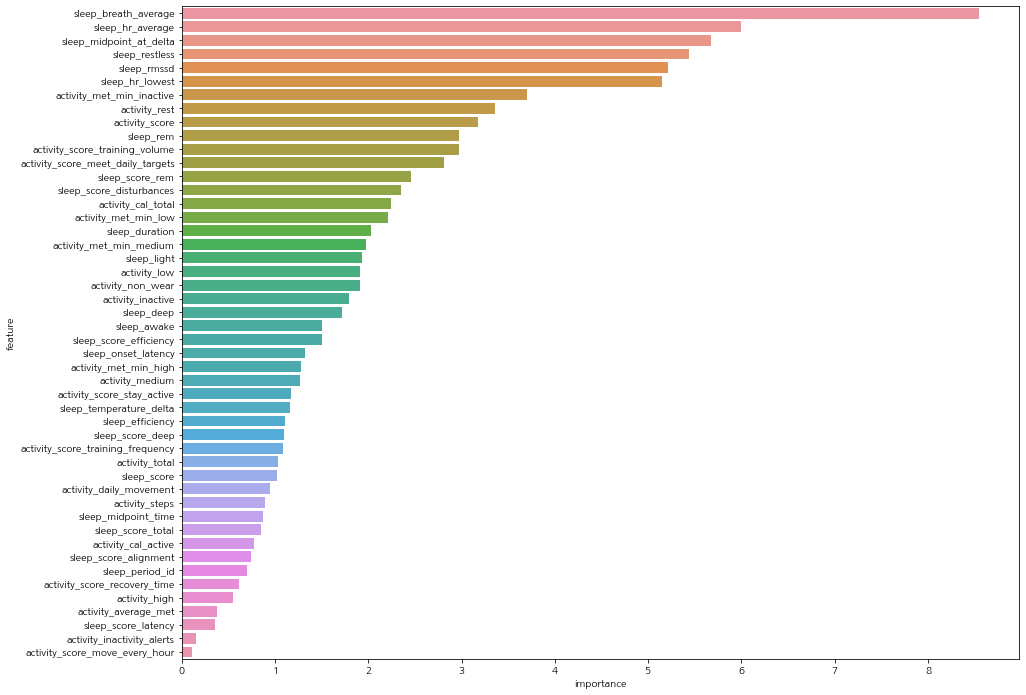

In [121]:
feature_importance = pd.DataFrame(test_X.columns, columns=["feature"])
feature_importance["importance"] = model_cat.feature_importances_
feature_importance = feature_importance.sort_values(by=["importance"], ascending=False)

plt.figure(figsize = (15,12))
sns.barplot(data=feature_importance, x="importance", y="feature")

In [122]:
# feature importance 에서 순위가 낮은 19개의 변수를 없애고 상위 30개의 변수에 대해서만 학습해 봅시다 
not_necessary = feature_importance.tail(18)["feature"].values
print(len(not_necessary))
print(not_necessary)

18
['sleep_efficiency' 'sleep_score_deep' 'activity_score_training_frequency'
 'activity_total' 'sleep_score' 'activity_daily_movement' 'activity_steps'
 'sleep_midpoint_time' 'sleep_score_total' 'activity_cal_active'
 'sleep_score_alignment' 'sleep_period_id' 'activity_score_recovery_time'
 'activity_high' 'activity_average_met' 'sleep_score_latency'
 'activity_inactivity_alerts' 'activity_score_move_every_hour']


In [123]:
input_data_X2 = input_data_X.drop(not_necessary, axis=1)

# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X2, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

In [124]:
model_cat2 = CatBoostClassifier()

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=5)
cv_accuracy = []
n_iter =0

for train_index, test_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    x_train, x_test = input_data_X2.iloc[train_index], input_data_X2.iloc[test_index]
    y_train, y_test = input_data_y[train_index], input_data_y[test_index]
    
    model_cat2.fit(x_train, y_train)
    pred = model_cat2.predict(x_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4) # 소수점 4자리 반올림
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, test_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))

Learning rate set to 0.086674
0:	learn: 1.0498329	total: 15.3ms	remaining: 15.3s
1:	learn: 1.0088892	total: 23.8ms	remaining: 11.9s
2:	learn: 0.9717722	total: 32.4ms	remaining: 10.8s
3:	learn: 0.9435761	total: 40.3ms	remaining: 10s
4:	learn: 0.9185013	total: 48.4ms	remaining: 9.63s
5:	learn: 0.8943808	total: 57ms	remaining: 9.44s
6:	learn: 0.8737957	total: 64.7ms	remaining: 9.18s
7:	learn: 0.8548884	total: 73.6ms	remaining: 9.12s
8:	learn: 0.8369143	total: 82.9ms	remaining: 9.13s
9:	learn: 0.8227052	total: 90.2ms	remaining: 8.93s
10:	learn: 0.8074940	total: 97.8ms	remaining: 8.8s
11:	learn: 0.7943127	total: 105ms	remaining: 8.68s
12:	learn: 0.7824282	total: 114ms	remaining: 8.66s
13:	learn: 0.7696675	total: 121ms	remaining: 8.55s
14:	learn: 0.7597801	total: 129ms	remaining: 8.46s
15:	learn: 0.7496119	total: 137ms	remaining: 8.39s
16:	learn: 0.7400412	total: 145ms	remaining: 8.39s
17:	learn: 0.7308401	total: 153ms	remaining: 8.32s
18:	learn: 0.7199631	total: 161ms	remaining: 8.29s
19:	l

173:	learn: 0.3302959	total: 1.49s	remaining: 7.08s
174:	learn: 0.3293408	total: 1.5s	remaining: 7.08s
175:	learn: 0.3284161	total: 1.51s	remaining: 7.07s
176:	learn: 0.3273686	total: 1.52s	remaining: 7.06s
177:	learn: 0.3265857	total: 1.53s	remaining: 7.05s
178:	learn: 0.3254939	total: 1.53s	remaining: 7.04s
179:	learn: 0.3249734	total: 1.54s	remaining: 7.03s
180:	learn: 0.3236874	total: 1.55s	remaining: 7.02s
181:	learn: 0.3225351	total: 1.56s	remaining: 7.02s
182:	learn: 0.3216861	total: 1.57s	remaining: 7.02s
183:	learn: 0.3207773	total: 1.58s	remaining: 7.01s
184:	learn: 0.3202189	total: 1.59s	remaining: 7s
185:	learn: 0.3188505	total: 1.59s	remaining: 6.98s
186:	learn: 0.3183546	total: 1.6s	remaining: 6.97s
187:	learn: 0.3170339	total: 1.61s	remaining: 6.96s
188:	learn: 0.3162328	total: 1.62s	remaining: 6.96s
189:	learn: 0.3152759	total: 1.63s	remaining: 6.95s
190:	learn: 0.3141027	total: 1.64s	remaining: 6.94s
191:	learn: 0.3130450	total: 1.65s	remaining: 6.93s
192:	learn: 0.311

341:	learn: 0.2182908	total: 3.07s	remaining: 5.9s
342:	learn: 0.2178500	total: 3.08s	remaining: 5.89s
343:	learn: 0.2174858	total: 3.08s	remaining: 5.88s
344:	learn: 0.2172491	total: 3.09s	remaining: 5.87s
345:	learn: 0.2169083	total: 3.1s	remaining: 5.86s
346:	learn: 0.2162301	total: 3.11s	remaining: 5.85s
347:	learn: 0.2158727	total: 3.12s	remaining: 5.84s
348:	learn: 0.2151826	total: 3.12s	remaining: 5.83s
349:	learn: 0.2147257	total: 3.13s	remaining: 5.82s
350:	learn: 0.2142338	total: 3.14s	remaining: 5.8s
351:	learn: 0.2139242	total: 3.15s	remaining: 5.79s
352:	learn: 0.2135356	total: 3.15s	remaining: 5.78s
353:	learn: 0.2132449	total: 3.16s	remaining: 5.77s
354:	learn: 0.2127373	total: 3.17s	remaining: 5.76s
355:	learn: 0.2123495	total: 3.18s	remaining: 5.75s
356:	learn: 0.2117527	total: 3.19s	remaining: 5.74s
357:	learn: 0.2113671	total: 3.19s	remaining: 5.73s
358:	learn: 0.2109261	total: 3.2s	remaining: 5.71s
359:	learn: 0.2104453	total: 3.21s	remaining: 5.71s
360:	learn: 0.21

501:	learn: 0.1600767	total: 4.42s	remaining: 4.39s
502:	learn: 0.1597544	total: 4.43s	remaining: 4.38s
503:	learn: 0.1594478	total: 4.45s	remaining: 4.38s
504:	learn: 0.1591031	total: 4.46s	remaining: 4.37s
505:	learn: 0.1589689	total: 4.47s	remaining: 4.36s
506:	learn: 0.1586749	total: 4.48s	remaining: 4.36s
507:	learn: 0.1585635	total: 4.49s	remaining: 4.34s
508:	learn: 0.1583476	total: 4.5s	remaining: 4.34s
509:	learn: 0.1581750	total: 4.5s	remaining: 4.33s
510:	learn: 0.1577956	total: 4.51s	remaining: 4.32s
511:	learn: 0.1575942	total: 4.52s	remaining: 4.31s
512:	learn: 0.1573680	total: 4.53s	remaining: 4.3s
513:	learn: 0.1572173	total: 4.54s	remaining: 4.29s
514:	learn: 0.1569636	total: 4.54s	remaining: 4.28s
515:	learn: 0.1568753	total: 4.55s	remaining: 4.27s
516:	learn: 0.1565748	total: 4.56s	remaining: 4.26s
517:	learn: 0.1563755	total: 4.57s	remaining: 4.25s
518:	learn: 0.1562018	total: 4.58s	remaining: 4.24s
519:	learn: 0.1560412	total: 4.59s	remaining: 4.23s
520:	learn: 0.1

673:	learn: 0.1213330	total: 5.96s	remaining: 2.88s
674:	learn: 0.1209817	total: 5.97s	remaining: 2.87s
675:	learn: 0.1207143	total: 5.98s	remaining: 2.87s
676:	learn: 0.1205696	total: 5.99s	remaining: 2.86s
677:	learn: 0.1204016	total: 6s	remaining: 2.85s
678:	learn: 0.1202815	total: 6s	remaining: 2.84s
679:	learn: 0.1200897	total: 6.01s	remaining: 2.83s
680:	learn: 0.1199796	total: 6.02s	remaining: 2.82s
681:	learn: 0.1197738	total: 6.03s	remaining: 2.81s
682:	learn: 0.1196268	total: 6.04s	remaining: 2.8s
683:	learn: 0.1194996	total: 6.05s	remaining: 2.79s
684:	learn: 0.1192526	total: 6.06s	remaining: 2.79s
685:	learn: 0.1190755	total: 6.07s	remaining: 2.78s
686:	learn: 0.1189131	total: 6.08s	remaining: 2.77s
687:	learn: 0.1188664	total: 6.08s	remaining: 2.76s
688:	learn: 0.1186538	total: 6.09s	remaining: 2.75s
689:	learn: 0.1184899	total: 6.1s	remaining: 2.74s
690:	learn: 0.1183512	total: 6.11s	remaining: 2.73s
691:	learn: 0.1181337	total: 6.12s	remaining: 2.72s
692:	learn: 0.117961

846:	learn: 0.0937600	total: 7.67s	remaining: 1.39s
847:	learn: 0.0935813	total: 7.68s	remaining: 1.38s
848:	learn: 0.0934510	total: 7.69s	remaining: 1.37s
849:	learn: 0.0934028	total: 7.7s	remaining: 1.36s
850:	learn: 0.0932649	total: 7.71s	remaining: 1.35s
851:	learn: 0.0931636	total: 7.72s	remaining: 1.34s
852:	learn: 0.0931115	total: 7.73s	remaining: 1.33s
853:	learn: 0.0929940	total: 7.74s	remaining: 1.32s
854:	learn: 0.0928125	total: 7.75s	remaining: 1.31s
855:	learn: 0.0926801	total: 7.76s	remaining: 1.3s
856:	learn: 0.0925679	total: 7.77s	remaining: 1.29s
857:	learn: 0.0924180	total: 7.77s	remaining: 1.29s
858:	learn: 0.0922608	total: 7.78s	remaining: 1.28s
859:	learn: 0.0921340	total: 7.79s	remaining: 1.27s
860:	learn: 0.0920387	total: 7.8s	remaining: 1.26s
861:	learn: 0.0919193	total: 7.81s	remaining: 1.25s
862:	learn: 0.0917909	total: 7.82s	remaining: 1.24s
863:	learn: 0.0916509	total: 7.82s	remaining: 1.23s
864:	learn: 0.0915463	total: 7.83s	remaining: 1.22s
865:	learn: 0.0

11:	learn: 0.8169289	total: 135ms	remaining: 11.1s
12:	learn: 0.8008109	total: 143ms	remaining: 10.9s
13:	learn: 0.7872770	total: 151ms	remaining: 10.7s
14:	learn: 0.7774843	total: 159ms	remaining: 10.4s
15:	learn: 0.7620866	total: 167ms	remaining: 10.3s
16:	learn: 0.7529245	total: 175ms	remaining: 10.1s
17:	learn: 0.7434876	total: 183ms	remaining: 9.97s
18:	learn: 0.7375629	total: 191ms	remaining: 9.86s
19:	learn: 0.7293779	total: 198ms	remaining: 9.72s
20:	learn: 0.7215458	total: 206ms	remaining: 9.61s
21:	learn: 0.7144178	total: 214ms	remaining: 9.5s
22:	learn: 0.7057386	total: 222ms	remaining: 9.41s
23:	learn: 0.7009541	total: 229ms	remaining: 9.33s
24:	learn: 0.6942284	total: 238ms	remaining: 9.27s
25:	learn: 0.6872868	total: 246ms	remaining: 9.21s
26:	learn: 0.6795137	total: 254ms	remaining: 9.14s
27:	learn: 0.6741032	total: 262ms	remaining: 9.09s
28:	learn: 0.6676126	total: 270ms	remaining: 9.04s
29:	learn: 0.6615820	total: 277ms	remaining: 8.97s
30:	learn: 0.6555115	total: 285m

191:	learn: 0.3342219	total: 1.63s	remaining: 6.84s
192:	learn: 0.3334352	total: 1.63s	remaining: 6.83s
193:	learn: 0.3328205	total: 1.64s	remaining: 6.82s
194:	learn: 0.3316922	total: 1.65s	remaining: 6.81s
195:	learn: 0.3298525	total: 1.66s	remaining: 6.8s
196:	learn: 0.3291427	total: 1.67s	remaining: 6.79s
197:	learn: 0.3285347	total: 1.68s	remaining: 6.79s
198:	learn: 0.3271553	total: 1.68s	remaining: 6.78s
199:	learn: 0.3261870	total: 1.69s	remaining: 6.76s
200:	learn: 0.3250988	total: 1.7s	remaining: 6.75s
201:	learn: 0.3244716	total: 1.71s	remaining: 6.74s
202:	learn: 0.3233887	total: 1.71s	remaining: 6.73s
203:	learn: 0.3225838	total: 1.72s	remaining: 6.72s
204:	learn: 0.3216000	total: 1.73s	remaining: 6.71s
205:	learn: 0.3209483	total: 1.74s	remaining: 6.7s
206:	learn: 0.3198512	total: 1.75s	remaining: 6.7s
207:	learn: 0.3192565	total: 1.76s	remaining: 6.69s
208:	learn: 0.3185476	total: 1.76s	remaining: 6.68s
209:	learn: 0.3181514	total: 1.77s	remaining: 6.67s
210:	learn: 0.31

354:	learn: 0.2255551	total: 2.96s	remaining: 5.38s
355:	learn: 0.2251572	total: 2.97s	remaining: 5.38s
356:	learn: 0.2246493	total: 2.99s	remaining: 5.38s
357:	learn: 0.2240497	total: 3s	remaining: 5.38s
358:	learn: 0.2238274	total: 3.01s	remaining: 5.37s
359:	learn: 0.2231671	total: 3.02s	remaining: 5.37s
360:	learn: 0.2229083	total: 3.03s	remaining: 5.36s
361:	learn: 0.2224645	total: 3.04s	remaining: 5.36s
362:	learn: 0.2220213	total: 3.05s	remaining: 5.35s
363:	learn: 0.2218198	total: 3.06s	remaining: 5.34s
364:	learn: 0.2214269	total: 3.07s	remaining: 5.34s
365:	learn: 0.2210976	total: 3.07s	remaining: 5.33s
366:	learn: 0.2208571	total: 3.08s	remaining: 5.32s
367:	learn: 0.2203624	total: 3.09s	remaining: 5.31s
368:	learn: 0.2200993	total: 3.1s	remaining: 5.3s
369:	learn: 0.2197665	total: 3.1s	remaining: 5.29s
370:	learn: 0.2192698	total: 3.11s	remaining: 5.28s
371:	learn: 0.2187809	total: 3.12s	remaining: 5.27s
372:	learn: 0.2184017	total: 3.13s	remaining: 5.26s
373:	learn: 0.2178

513:	learn: 0.1689816	total: 4.28s	remaining: 4.05s
514:	learn: 0.1687887	total: 4.29s	remaining: 4.04s
515:	learn: 0.1682147	total: 4.3s	remaining: 4.03s
516:	learn: 0.1680833	total: 4.31s	remaining: 4.02s
517:	learn: 0.1678075	total: 4.32s	remaining: 4.01s
518:	learn: 0.1676511	total: 4.32s	remaining: 4.01s
519:	learn: 0.1674322	total: 4.33s	remaining: 4s
520:	learn: 0.1672977	total: 4.34s	remaining: 3.99s
521:	learn: 0.1669894	total: 4.35s	remaining: 3.98s
522:	learn: 0.1668206	total: 4.36s	remaining: 3.97s
523:	learn: 0.1666542	total: 4.37s	remaining: 3.96s
524:	learn: 0.1661520	total: 4.37s	remaining: 3.96s
525:	learn: 0.1657385	total: 4.38s	remaining: 3.95s
526:	learn: 0.1654462	total: 4.39s	remaining: 3.94s
527:	learn: 0.1649571	total: 4.4s	remaining: 3.93s
528:	learn: 0.1646403	total: 4.4s	remaining: 3.92s
529:	learn: 0.1643050	total: 4.41s	remaining: 3.91s
530:	learn: 0.1640743	total: 4.42s	remaining: 3.9s
531:	learn: 0.1637266	total: 4.43s	remaining: 3.9s
532:	learn: 0.163640

672:	learn: 0.1320994	total: 5.58s	remaining: 2.71s
673:	learn: 0.1318999	total: 5.59s	remaining: 2.7s
674:	learn: 0.1316881	total: 5.6s	remaining: 2.7s
675:	learn: 0.1315042	total: 5.61s	remaining: 2.69s
676:	learn: 0.1313424	total: 5.62s	remaining: 2.68s
677:	learn: 0.1309932	total: 5.62s	remaining: 2.67s
678:	learn: 0.1306674	total: 5.63s	remaining: 2.66s
679:	learn: 0.1303578	total: 5.64s	remaining: 2.65s
680:	learn: 0.1302463	total: 5.65s	remaining: 2.65s
681:	learn: 0.1299631	total: 5.66s	remaining: 2.64s
682:	learn: 0.1298270	total: 5.66s	remaining: 2.63s
683:	learn: 0.1296064	total: 5.67s	remaining: 2.62s
684:	learn: 0.1294745	total: 5.68s	remaining: 2.61s
685:	learn: 0.1292313	total: 5.69s	remaining: 2.6s
686:	learn: 0.1290571	total: 5.69s	remaining: 2.59s
687:	learn: 0.1288585	total: 5.7s	remaining: 2.58s
688:	learn: 0.1286822	total: 5.71s	remaining: 2.58s
689:	learn: 0.1285395	total: 5.72s	remaining: 2.57s
690:	learn: 0.1284185	total: 5.73s	remaining: 2.56s
691:	learn: 0.128

843:	learn: 0.1041072	total: 7.08s	remaining: 1.31s
844:	learn: 0.1039883	total: 7.08s	remaining: 1.3s
845:	learn: 0.1037494	total: 7.09s	remaining: 1.29s
846:	learn: 0.1036289	total: 7.1s	remaining: 1.28s
847:	learn: 0.1035312	total: 7.11s	remaining: 1.27s
848:	learn: 0.1033878	total: 7.12s	remaining: 1.26s
849:	learn: 0.1032472	total: 7.13s	remaining: 1.26s
850:	learn: 0.1031469	total: 7.13s	remaining: 1.25s
851:	learn: 0.1029517	total: 7.14s	remaining: 1.24s
852:	learn: 0.1027126	total: 7.15s	remaining: 1.23s
853:	learn: 0.1026126	total: 7.16s	remaining: 1.22s
854:	learn: 0.1024668	total: 7.17s	remaining: 1.22s
855:	learn: 0.1022668	total: 7.18s	remaining: 1.21s
856:	learn: 0.1021693	total: 7.18s	remaining: 1.2s
857:	learn: 0.1020931	total: 7.19s	remaining: 1.19s
858:	learn: 0.1020126	total: 7.2s	remaining: 1.18s
859:	learn: 0.1018411	total: 7.21s	remaining: 1.17s
860:	learn: 0.1017224	total: 7.22s	remaining: 1.16s
861:	learn: 0.1016035	total: 7.22s	remaining: 1.16s
862:	learn: 0.10

7:	learn: 0.8420377	total: 115ms	remaining: 14.3s
8:	learn: 0.8231799	total: 123ms	remaining: 13.5s
9:	learn: 0.8083109	total: 131ms	remaining: 12.9s
10:	learn: 0.7932094	total: 138ms	remaining: 12.4s
11:	learn: 0.7797280	total: 146ms	remaining: 12s
12:	learn: 0.7642887	total: 154ms	remaining: 11.7s
13:	learn: 0.7525852	total: 162ms	remaining: 11.4s
14:	learn: 0.7430695	total: 169ms	remaining: 11.1s
15:	learn: 0.7294683	total: 177ms	remaining: 10.9s
16:	learn: 0.7202805	total: 185ms	remaining: 10.7s
17:	learn: 0.7113098	total: 192ms	remaining: 10.5s
18:	learn: 0.7027529	total: 200ms	remaining: 10.3s
19:	learn: 0.6937582	total: 208ms	remaining: 10.2s
20:	learn: 0.6866778	total: 215ms	remaining: 10s
21:	learn: 0.6793481	total: 223ms	remaining: 9.92s
22:	learn: 0.6729275	total: 231ms	remaining: 9.82s
23:	learn: 0.6666986	total: 240ms	remaining: 9.76s
24:	learn: 0.6601195	total: 248ms	remaining: 9.66s
25:	learn: 0.6546600	total: 255ms	remaining: 9.55s
26:	learn: 0.6495797	total: 263ms	rema

172:	learn: 0.3176155	total: 1.42s	remaining: 6.78s
173:	learn: 0.3170092	total: 1.43s	remaining: 6.77s
174:	learn: 0.3159607	total: 1.43s	remaining: 6.76s
175:	learn: 0.3149749	total: 1.44s	remaining: 6.75s
176:	learn: 0.3141377	total: 1.45s	remaining: 6.74s
177:	learn: 0.3130267	total: 1.46s	remaining: 6.73s
178:	learn: 0.3122782	total: 1.47s	remaining: 6.72s
179:	learn: 0.3105774	total: 1.47s	remaining: 6.71s
180:	learn: 0.3099924	total: 1.48s	remaining: 6.71s
181:	learn: 0.3093727	total: 1.49s	remaining: 6.69s
182:	learn: 0.3083294	total: 1.5s	remaining: 6.68s
183:	learn: 0.3075078	total: 1.5s	remaining: 6.67s
184:	learn: 0.3064987	total: 1.51s	remaining: 6.67s
185:	learn: 0.3052163	total: 1.52s	remaining: 6.66s
186:	learn: 0.3042913	total: 1.53s	remaining: 6.64s
187:	learn: 0.3032695	total: 1.54s	remaining: 6.64s
188:	learn: 0.3026864	total: 1.54s	remaining: 6.63s
189:	learn: 0.3015451	total: 1.55s	remaining: 6.62s
190:	learn: 0.3005409	total: 1.56s	remaining: 6.61s
191:	learn: 0.

339:	learn: 0.2101535	total: 2.75s	remaining: 5.33s
340:	learn: 0.2095207	total: 2.75s	remaining: 5.32s
341:	learn: 0.2091956	total: 2.76s	remaining: 5.31s
342:	learn: 0.2087625	total: 2.77s	remaining: 5.3s
343:	learn: 0.2081172	total: 2.78s	remaining: 5.3s
344:	learn: 0.2076922	total: 2.79s	remaining: 5.29s
345:	learn: 0.2073621	total: 2.79s	remaining: 5.28s
346:	learn: 0.2069299	total: 2.8s	remaining: 5.27s
347:	learn: 0.2065665	total: 2.81s	remaining: 5.26s
348:	learn: 0.2060493	total: 2.81s	remaining: 5.25s
349:	learn: 0.2057044	total: 2.82s	remaining: 5.25s
350:	learn: 0.2050089	total: 2.83s	remaining: 5.24s
351:	learn: 0.2047768	total: 2.84s	remaining: 5.23s
352:	learn: 0.2043959	total: 2.85s	remaining: 5.22s
353:	learn: 0.2041349	total: 2.86s	remaining: 5.21s
354:	learn: 0.2035224	total: 2.87s	remaining: 5.21s
355:	learn: 0.2029593	total: 2.87s	remaining: 5.2s
356:	learn: 0.2020582	total: 2.88s	remaining: 5.19s
357:	learn: 0.2016726	total: 2.89s	remaining: 5.18s
358:	learn: 0.20

502:	learn: 0.1524787	total: 4.04s	remaining: 4s
503:	learn: 0.1523397	total: 4.05s	remaining: 3.99s
504:	learn: 0.1519734	total: 4.06s	remaining: 3.98s
505:	learn: 0.1517448	total: 4.07s	remaining: 3.97s
506:	learn: 0.1512713	total: 4.08s	remaining: 3.97s
507:	learn: 0.1508856	total: 4.09s	remaining: 3.96s
508:	learn: 0.1505176	total: 4.09s	remaining: 3.95s
509:	learn: 0.1503186	total: 4.1s	remaining: 3.94s
510:	learn: 0.1500755	total: 4.11s	remaining: 3.93s
511:	learn: 0.1496764	total: 4.12s	remaining: 3.92s
512:	learn: 0.1494598	total: 4.13s	remaining: 3.92s
513:	learn: 0.1491890	total: 4.13s	remaining: 3.91s
514:	learn: 0.1489028	total: 4.14s	remaining: 3.9s
515:	learn: 0.1485180	total: 4.15s	remaining: 3.89s
516:	learn: 0.1481649	total: 4.16s	remaining: 3.88s
517:	learn: 0.1479171	total: 4.17s	remaining: 3.88s
518:	learn: 0.1475993	total: 4.17s	remaining: 3.87s
519:	learn: 0.1474172	total: 4.18s	remaining: 3.86s
520:	learn: 0.1471839	total: 4.19s	remaining: 3.85s
521:	learn: 0.146

661:	learn: 0.1147598	total: 5.35s	remaining: 2.73s
662:	learn: 0.1144697	total: 5.36s	remaining: 2.72s
663:	learn: 0.1143498	total: 5.36s	remaining: 2.71s
664:	learn: 0.1141540	total: 5.37s	remaining: 2.71s
665:	learn: 0.1138847	total: 5.38s	remaining: 2.7s
666:	learn: 0.1137058	total: 5.39s	remaining: 2.69s
667:	learn: 0.1136067	total: 5.4s	remaining: 2.68s
668:	learn: 0.1134620	total: 5.4s	remaining: 2.67s
669:	learn: 0.1133317	total: 5.41s	remaining: 2.67s
670:	learn: 0.1131896	total: 5.42s	remaining: 2.66s
671:	learn: 0.1129982	total: 5.43s	remaining: 2.65s
672:	learn: 0.1128954	total: 5.43s	remaining: 2.64s
673:	learn: 0.1127295	total: 5.44s	remaining: 2.63s
674:	learn: 0.1125956	total: 5.45s	remaining: 2.62s
675:	learn: 0.1123916	total: 5.46s	remaining: 2.62s
676:	learn: 0.1123260	total: 5.47s	remaining: 2.61s
677:	learn: 0.1121472	total: 5.48s	remaining: 2.6s
678:	learn: 0.1118947	total: 5.48s	remaining: 2.59s
679:	learn: 0.1117755	total: 5.49s	remaining: 2.58s
680:	learn: 0.11

823:	learn: 0.0901711	total: 6.65s	remaining: 1.42s
824:	learn: 0.0900147	total: 6.66s	remaining: 1.41s
825:	learn: 0.0899041	total: 6.66s	remaining: 1.4s
826:	learn: 0.0897270	total: 6.67s	remaining: 1.4s
827:	learn: 0.0895688	total: 6.68s	remaining: 1.39s
828:	learn: 0.0894762	total: 6.69s	remaining: 1.38s
829:	learn: 0.0893457	total: 6.7s	remaining: 1.37s
830:	learn: 0.0891537	total: 6.7s	remaining: 1.36s
831:	learn: 0.0890806	total: 6.71s	remaining: 1.35s
832:	learn: 0.0888358	total: 6.72s	remaining: 1.35s
833:	learn: 0.0887374	total: 6.73s	remaining: 1.34s
834:	learn: 0.0886214	total: 6.74s	remaining: 1.33s
835:	learn: 0.0885401	total: 6.74s	remaining: 1.32s
836:	learn: 0.0884959	total: 6.75s	remaining: 1.31s
837:	learn: 0.0884157	total: 6.76s	remaining: 1.31s
838:	learn: 0.0882322	total: 6.77s	remaining: 1.3s
839:	learn: 0.0880047	total: 6.77s	remaining: 1.29s
840:	learn: 0.0878134	total: 6.78s	remaining: 1.28s
841:	learn: 0.0876483	total: 6.79s	remaining: 1.27s
842:	learn: 0.087

985:	learn: 0.0722601	total: 7.95s	remaining: 113ms
986:	learn: 0.0721576	total: 7.96s	remaining: 105ms
987:	learn: 0.0720981	total: 7.96s	remaining: 96.7ms
988:	learn: 0.0720100	total: 7.97s	remaining: 88.7ms
989:	learn: 0.0718275	total: 7.98s	remaining: 80.6ms
990:	learn: 0.0717601	total: 7.99s	remaining: 72.5ms
991:	learn: 0.0716835	total: 7.99s	remaining: 64.5ms
992:	learn: 0.0716139	total: 8s	remaining: 56.4ms
993:	learn: 0.0714992	total: 8.01s	remaining: 48.4ms
994:	learn: 0.0714384	total: 8.02s	remaining: 40.3ms
995:	learn: 0.0713493	total: 8.03s	remaining: 32.2ms
996:	learn: 0.0711895	total: 8.03s	remaining: 24.2ms
997:	learn: 0.0711444	total: 8.04s	remaining: 16.1ms
998:	learn: 0.0709724	total: 8.05s	remaining: 8.06ms
999:	learn: 0.0708611	total: 8.06s	remaining: 0us

#3 교차 검증 정확도 : 0.5335,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#3 검증 세트 인덱스 : [2970 2971 2972 ... 4530 4532 4561]
Learning rate set to 0.086675
0:	learn: 1.0525418	total: 9.85ms	remaining: 9.84s
1:	learn: 1.0118713	

152:	learn: 0.3729195	total: 1.25s	remaining: 6.91s
153:	learn: 0.3720845	total: 1.26s	remaining: 6.91s
154:	learn: 0.3710649	total: 1.26s	remaining: 6.89s
155:	learn: 0.3699837	total: 1.27s	remaining: 6.88s
156:	learn: 0.3689593	total: 1.28s	remaining: 6.88s
157:	learn: 0.3680087	total: 1.29s	remaining: 6.87s
158:	learn: 0.3662378	total: 1.3s	remaining: 6.86s
159:	learn: 0.3650300	total: 1.3s	remaining: 6.85s
160:	learn: 0.3643818	total: 1.31s	remaining: 6.83s
161:	learn: 0.3637411	total: 1.32s	remaining: 6.83s
162:	learn: 0.3626705	total: 1.33s	remaining: 6.82s
163:	learn: 0.3613149	total: 1.34s	remaining: 6.81s
164:	learn: 0.3606199	total: 1.34s	remaining: 6.8s
165:	learn: 0.3592213	total: 1.35s	remaining: 6.79s
166:	learn: 0.3582135	total: 1.36s	remaining: 6.79s
167:	learn: 0.3566071	total: 1.37s	remaining: 6.79s
168:	learn: 0.3559866	total: 1.38s	remaining: 6.78s
169:	learn: 0.3546040	total: 1.39s	remaining: 6.76s
170:	learn: 0.3534934	total: 1.39s	remaining: 6.75s
171:	learn: 0.3

312:	learn: 0.2513410	total: 2.56s	remaining: 5.61s
313:	learn: 0.2507146	total: 2.56s	remaining: 5.6s
314:	learn: 0.2504810	total: 2.57s	remaining: 5.59s
315:	learn: 0.2499133	total: 2.58s	remaining: 5.58s
316:	learn: 0.2492910	total: 2.59s	remaining: 5.57s
317:	learn: 0.2491028	total: 2.6s	remaining: 5.57s
318:	learn: 0.2485596	total: 2.6s	remaining: 5.56s
319:	learn: 0.2480139	total: 2.61s	remaining: 5.55s
320:	learn: 0.2472468	total: 2.62s	remaining: 5.54s
321:	learn: 0.2468684	total: 2.63s	remaining: 5.54s
322:	learn: 0.2464790	total: 2.64s	remaining: 5.53s
323:	learn: 0.2459659	total: 2.65s	remaining: 5.52s
324:	learn: 0.2453836	total: 2.65s	remaining: 5.51s
325:	learn: 0.2450787	total: 2.66s	remaining: 5.5s
326:	learn: 0.2445125	total: 2.67s	remaining: 5.49s
327:	learn: 0.2437395	total: 2.68s	remaining: 5.48s
328:	learn: 0.2436329	total: 2.68s	remaining: 5.47s
329:	learn: 0.2432303	total: 2.69s	remaining: 5.47s
330:	learn: 0.2429489	total: 2.7s	remaining: 5.46s
331:	learn: 0.242

473:	learn: 0.1866319	total: 3.87s	remaining: 4.29s
474:	learn: 0.1860526	total: 3.87s	remaining: 4.28s
475:	learn: 0.1857933	total: 3.88s	remaining: 4.27s
476:	learn: 0.1854465	total: 3.89s	remaining: 4.27s
477:	learn: 0.1851691	total: 3.9s	remaining: 4.26s
478:	learn: 0.1848819	total: 3.91s	remaining: 4.25s
479:	learn: 0.1844744	total: 3.92s	remaining: 4.24s
480:	learn: 0.1841329	total: 3.92s	remaining: 4.23s
481:	learn: 0.1838790	total: 3.93s	remaining: 4.23s
482:	learn: 0.1836046	total: 3.94s	remaining: 4.22s
483:	learn: 0.1831402	total: 3.95s	remaining: 4.21s
484:	learn: 0.1828055	total: 3.96s	remaining: 4.2s
485:	learn: 0.1825239	total: 3.96s	remaining: 4.19s
486:	learn: 0.1822046	total: 3.97s	remaining: 4.18s
487:	learn: 0.1818457	total: 3.98s	remaining: 4.17s
488:	learn: 0.1816620	total: 3.99s	remaining: 4.17s
489:	learn: 0.1813928	total: 4s	remaining: 4.16s
490:	learn: 0.1811115	total: 4s	remaining: 4.15s
491:	learn: 0.1808232	total: 4.01s	remaining: 4.14s
492:	learn: 0.180555

634:	learn: 0.1438574	total: 5.17s	remaining: 2.97s
635:	learn: 0.1436124	total: 5.18s	remaining: 2.96s
636:	learn: 0.1432573	total: 5.19s	remaining: 2.96s
637:	learn: 0.1429533	total: 5.19s	remaining: 2.95s
638:	learn: 0.1427425	total: 5.2s	remaining: 2.94s
639:	learn: 0.1426232	total: 5.21s	remaining: 2.93s
640:	learn: 0.1422812	total: 5.22s	remaining: 2.92s
641:	learn: 0.1421839	total: 5.22s	remaining: 2.91s
642:	learn: 0.1420664	total: 5.23s	remaining: 2.9s
643:	learn: 0.1419214	total: 5.24s	remaining: 2.9s
644:	learn: 0.1418142	total: 5.25s	remaining: 2.89s
645:	learn: 0.1414525	total: 5.26s	remaining: 2.88s
646:	learn: 0.1410959	total: 5.26s	remaining: 2.87s
647:	learn: 0.1408800	total: 5.27s	remaining: 2.86s
648:	learn: 0.1407074	total: 5.28s	remaining: 2.86s
649:	learn: 0.1404434	total: 5.29s	remaining: 2.85s
650:	learn: 0.1402482	total: 5.3s	remaining: 2.84s
651:	learn: 0.1399834	total: 5.31s	remaining: 2.83s
652:	learn: 0.1396222	total: 5.32s	remaining: 2.83s
653:	learn: 0.13

814:	learn: 0.1101818	total: 6.64s	remaining: 1.51s
815:	learn: 0.1100350	total: 6.64s	remaining: 1.5s
816:	learn: 0.1099056	total: 6.65s	remaining: 1.49s
817:	learn: 0.1097646	total: 6.66s	remaining: 1.48s
818:	learn: 0.1094038	total: 6.67s	remaining: 1.47s
819:	learn: 0.1092010	total: 6.68s	remaining: 1.47s
820:	learn: 0.1089458	total: 6.68s	remaining: 1.46s
821:	learn: 0.1088091	total: 6.69s	remaining: 1.45s
822:	learn: 0.1087181	total: 6.7s	remaining: 1.44s
823:	learn: 0.1086179	total: 6.71s	remaining: 1.43s
824:	learn: 0.1084543	total: 6.71s	remaining: 1.42s
825:	learn: 0.1083874	total: 6.72s	remaining: 1.42s
826:	learn: 0.1082562	total: 6.73s	remaining: 1.41s
827:	learn: 0.1081596	total: 6.74s	remaining: 1.4s
828:	learn: 0.1080227	total: 6.75s	remaining: 1.39s
829:	learn: 0.1078298	total: 6.76s	remaining: 1.38s
830:	learn: 0.1076838	total: 6.76s	remaining: 1.38s
831:	learn: 0.1075726	total: 6.77s	remaining: 1.37s
832:	learn: 0.1074809	total: 6.78s	remaining: 1.36s
833:	learn: 0.1

995:	learn: 0.0878469	total: 8.13s	remaining: 32.7ms
996:	learn: 0.0877595	total: 8.14s	remaining: 24.5ms
997:	learn: 0.0875742	total: 8.15s	remaining: 16.3ms
998:	learn: 0.0874141	total: 8.16s	remaining: 8.16ms
999:	learn: 0.0872013	total: 8.16s	remaining: 0us

#4 교차 검증 정확도 : 0.5389,  학습 데이터 크기 : 5969,  검증 데이터 크기 : 1492
#4 검증 세트 인덱스 : [4448 4449 4450 ... 5998 5999 6000]
Learning rate set to 0.086675
0:	learn: 1.0535526	total: 49.7ms	remaining: 49.6s
1:	learn: 1.0115921	total: 72.9ms	remaining: 36.4s
2:	learn: 0.9747355	total: 87.5ms	remaining: 29.1s
3:	learn: 0.9447275	total: 98.3ms	remaining: 24.5s
4:	learn: 0.9168535	total: 107ms	remaining: 21.3s
5:	learn: 0.8907479	total: 116ms	remaining: 19.2s
6:	learn: 0.8679712	total: 124ms	remaining: 17.6s
7:	learn: 0.8488024	total: 132ms	remaining: 16.4s
8:	learn: 0.8284018	total: 139ms	remaining: 15.3s
9:	learn: 0.8112333	total: 149ms	remaining: 14.7s
10:	learn: 0.7946891	total: 157ms	remaining: 14.1s
11:	learn: 0.7813585	total: 165ms	remaini

159:	learn: 0.3413732	total: 1.36s	remaining: 7.17s
160:	learn: 0.3400390	total: 1.37s	remaining: 7.16s
161:	learn: 0.3391516	total: 1.38s	remaining: 7.15s
162:	learn: 0.3378851	total: 1.39s	remaining: 7.14s
163:	learn: 0.3369977	total: 1.4s	remaining: 7.12s
164:	learn: 0.3358025	total: 1.41s	remaining: 7.11s
165:	learn: 0.3352183	total: 1.41s	remaining: 7.1s
166:	learn: 0.3344880	total: 1.42s	remaining: 7.09s
167:	learn: 0.3327716	total: 1.43s	remaining: 7.08s
168:	learn: 0.3313992	total: 1.44s	remaining: 7.07s
169:	learn: 0.3305555	total: 1.44s	remaining: 7.05s
170:	learn: 0.3293055	total: 1.45s	remaining: 7.04s
171:	learn: 0.3278794	total: 1.46s	remaining: 7.03s
172:	learn: 0.3268433	total: 1.47s	remaining: 7.02s
173:	learn: 0.3257561	total: 1.48s	remaining: 7.01s
174:	learn: 0.3246858	total: 1.48s	remaining: 7s
175:	learn: 0.3231162	total: 1.49s	remaining: 6.99s
176:	learn: 0.3219869	total: 1.5s	remaining: 6.99s
177:	learn: 0.3213075	total: 1.51s	remaining: 6.98s
178:	learn: 0.3205

320:	learn: 0.2205841	total: 2.67s	remaining: 5.64s
321:	learn: 0.2200973	total: 2.67s	remaining: 5.63s
322:	learn: 0.2196293	total: 2.68s	remaining: 5.62s
323:	learn: 0.2187708	total: 2.69s	remaining: 5.62s
324:	learn: 0.2184500	total: 2.7s	remaining: 5.61s
325:	learn: 0.2178535	total: 2.71s	remaining: 5.6s
326:	learn: 0.2172361	total: 2.72s	remaining: 5.59s
327:	learn: 0.2162915	total: 2.73s	remaining: 5.58s
328:	learn: 0.2161402	total: 2.73s	remaining: 5.58s
329:	learn: 0.2154651	total: 2.74s	remaining: 5.57s
330:	learn: 0.2149841	total: 2.75s	remaining: 5.56s
331:	learn: 0.2146310	total: 2.76s	remaining: 5.55s
332:	learn: 0.2140904	total: 2.77s	remaining: 5.54s
333:	learn: 0.2135661	total: 2.77s	remaining: 5.53s
334:	learn: 0.2130423	total: 2.78s	remaining: 5.52s
335:	learn: 0.2127836	total: 2.79s	remaining: 5.52s
336:	learn: 0.2123504	total: 2.8s	remaining: 5.51s
337:	learn: 0.2116396	total: 2.81s	remaining: 5.5s
338:	learn: 0.2111704	total: 2.81s	remaining: 5.49s
339:	learn: 0.21

486:	learn: 0.1561836	total: 4.03s	remaining: 4.25s
487:	learn: 0.1556686	total: 4.04s	remaining: 4.24s
488:	learn: 0.1553824	total: 4.05s	remaining: 4.23s
489:	learn: 0.1549898	total: 4.06s	remaining: 4.22s
490:	learn: 0.1546068	total: 4.07s	remaining: 4.21s
491:	learn: 0.1540983	total: 4.07s	remaining: 4.21s
492:	learn: 0.1537591	total: 4.08s	remaining: 4.2s
493:	learn: 0.1534648	total: 4.09s	remaining: 4.19s
494:	learn: 0.1532768	total: 4.1s	remaining: 4.18s
495:	learn: 0.1530160	total: 4.11s	remaining: 4.17s
496:	learn: 0.1526954	total: 4.11s	remaining: 4.16s
497:	learn: 0.1524800	total: 4.12s	remaining: 4.16s
498:	learn: 0.1522777	total: 4.13s	remaining: 4.15s
499:	learn: 0.1518179	total: 4.14s	remaining: 4.14s
500:	learn: 0.1516421	total: 4.15s	remaining: 4.13s
501:	learn: 0.1514030	total: 4.16s	remaining: 4.12s
502:	learn: 0.1510355	total: 4.16s	remaining: 4.11s
503:	learn: 0.1507438	total: 4.17s	remaining: 4.1s
504:	learn: 0.1504587	total: 4.18s	remaining: 4.1s
505:	learn: 0.15

648:	learn: 0.1166092	total: 5.36s	remaining: 2.9s
649:	learn: 0.1163405	total: 5.37s	remaining: 2.89s
650:	learn: 0.1161648	total: 5.37s	remaining: 2.88s
651:	learn: 0.1161048	total: 5.38s	remaining: 2.87s
652:	learn: 0.1159464	total: 5.39s	remaining: 2.87s
653:	learn: 0.1157392	total: 5.4s	remaining: 2.86s
654:	learn: 0.1155215	total: 5.41s	remaining: 2.85s
655:	learn: 0.1154546	total: 5.42s	remaining: 2.84s
656:	learn: 0.1152016	total: 5.42s	remaining: 2.83s
657:	learn: 0.1150834	total: 5.43s	remaining: 2.82s
658:	learn: 0.1149173	total: 5.44s	remaining: 2.82s
659:	learn: 0.1147452	total: 5.45s	remaining: 2.81s
660:	learn: 0.1144252	total: 5.46s	remaining: 2.8s
661:	learn: 0.1143107	total: 5.47s	remaining: 2.79s
662:	learn: 0.1140560	total: 5.47s	remaining: 2.78s
663:	learn: 0.1138951	total: 5.48s	remaining: 2.77s
664:	learn: 0.1138088	total: 5.49s	remaining: 2.77s
665:	learn: 0.1136077	total: 5.5s	remaining: 2.76s
666:	learn: 0.1134922	total: 5.51s	remaining: 2.75s
667:	learn: 0.11

807:	learn: 0.0921118	total: 6.66s	remaining: 1.58s
808:	learn: 0.0920129	total: 6.67s	remaining: 1.57s
809:	learn: 0.0918603	total: 6.67s	remaining: 1.56s
810:	learn: 0.0917005	total: 6.68s	remaining: 1.56s
811:	learn: 0.0916280	total: 6.69s	remaining: 1.55s
812:	learn: 0.0914535	total: 6.7s	remaining: 1.54s
813:	learn: 0.0913171	total: 6.71s	remaining: 1.53s
814:	learn: 0.0912752	total: 6.72s	remaining: 1.52s
815:	learn: 0.0911226	total: 6.72s	remaining: 1.52s
816:	learn: 0.0909842	total: 6.73s	remaining: 1.51s
817:	learn: 0.0908319	total: 6.74s	remaining: 1.5s
818:	learn: 0.0906014	total: 6.75s	remaining: 1.49s
819:	learn: 0.0904891	total: 6.76s	remaining: 1.48s
820:	learn: 0.0903744	total: 6.76s	remaining: 1.48s
821:	learn: 0.0902383	total: 6.77s	remaining: 1.47s
822:	learn: 0.0900769	total: 6.78s	remaining: 1.46s
823:	learn: 0.0899711	total: 6.79s	remaining: 1.45s
824:	learn: 0.0897724	total: 6.8s	remaining: 1.44s
825:	learn: 0.0897290	total: 6.8s	remaining: 1.43s
826:	learn: 0.08

978:	learn: 0.0732880	total: 8.15s	remaining: 175ms
979:	learn: 0.0731962	total: 8.16s	remaining: 167ms
980:	learn: 0.0730947	total: 8.17s	remaining: 158ms
981:	learn: 0.0730125	total: 8.18s	remaining: 150ms
982:	learn: 0.0728940	total: 8.19s	remaining: 142ms
983:	learn: 0.0727893	total: 8.2s	remaining: 133ms
984:	learn: 0.0727000	total: 8.21s	remaining: 125ms
985:	learn: 0.0726153	total: 8.22s	remaining: 117ms
986:	learn: 0.0725638	total: 8.23s	remaining: 108ms
987:	learn: 0.0724989	total: 8.24s	remaining: 100ms
988:	learn: 0.0724221	total: 8.25s	remaining: 91.7ms
989:	learn: 0.0723584	total: 8.26s	remaining: 83.4ms
990:	learn: 0.0722267	total: 8.27s	remaining: 75.1ms
991:	learn: 0.0721213	total: 8.28s	remaining: 66.7ms
992:	learn: 0.0719999	total: 8.28s	remaining: 58.4ms
993:	learn: 0.0719061	total: 8.29s	remaining: 50.1ms
994:	learn: 0.0718010	total: 8.3s	remaining: 41.7ms
995:	learn: 0.0717257	total: 8.31s	remaining: 33.4ms
996:	learn: 0.0716681	total: 8.32s	remaining: 25ms
997:	le

In [125]:
pred_cat_prob = model_cat2.predict_proba(test_X)
pred_cat = np.argmax(pred_cat_prob, axis=1)

print(classification_report(test_y, pred_cat))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91      1194
           1       0.89      0.83      0.86       129
           2       0.84      0.74      0.79       543

    accuracy                           0.87      1866
   macro avg       0.87      0.83      0.85      1866
weighted avg       0.87      0.87      0.87      1866



# 6. Evaluation

- precision(정밀도) : True -> True 
- Recall(재현율) : True인 것을 맞춘 비율 
- F1 score : precision 과 recall의 조화평균

In [140]:
def show_pred(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    
    df_result = pd.DataFrame(list(zip(true_y, pred)), columns=['true_y', 'prediction'])
    return df_result
    
def show_prediction_error(test_y, pred) :
    #true_y = test_y.to_numpy()
    true_y = np.ravel(test_y)
    error = pred - true_y
    plt.hist(error, bins=25)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")
    
def graph(pred, test_label) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

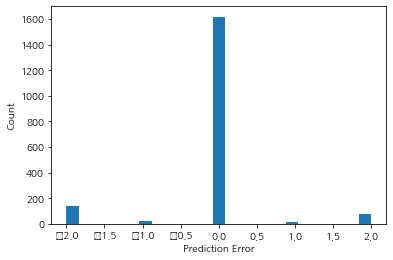

In [142]:
show_prediction_error(test_y, pred_xgb)